In [11]:
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import json

In [12]:
with open('data.json', 'r', encoding='utf-8') as f:
    raw_data = json.load(f)

data = {}
scale = 10 # q-value가 너무 크게 변해 alpha가 0에 가까워지는 현상 방지

for subj, lists in raw_data.items():
    choices, gains, losses, rewards = lists
    choices = (np.array(choices, dtype=int) - 1) # 1~4 -> 0~3
    gains = np.array(gains, dtype=float) / scale
    losses = np.array(losses, dtype=float) / scale
    rewards = np.array(rewards, dtype=float) / scale

    data[int(subj)] = {
        "choices": choices,
        "gains": gains,
        "losses": losses,
        "rewards": rewards,
    }

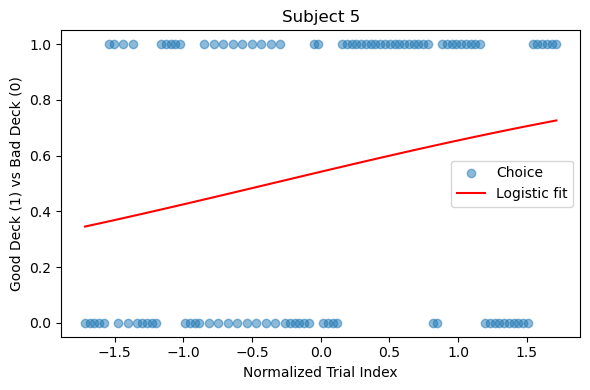

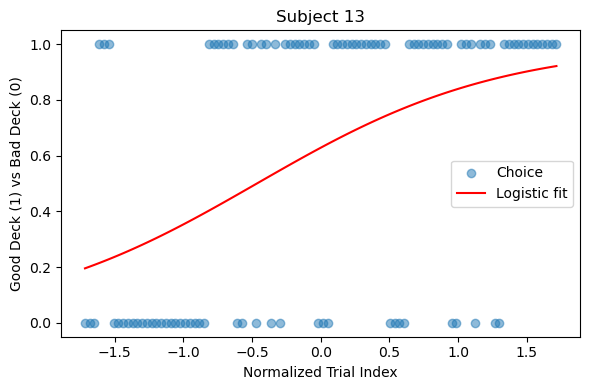

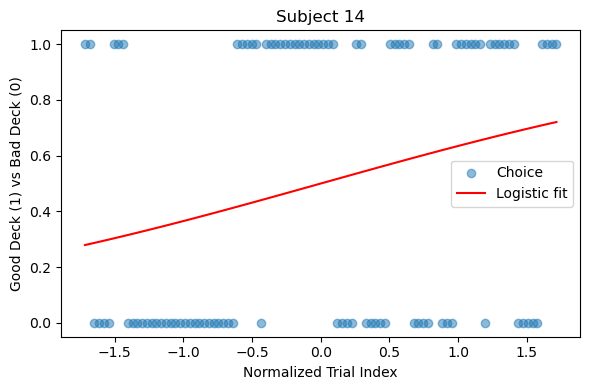

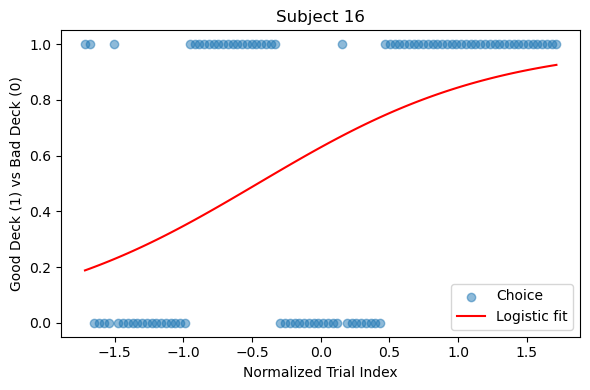

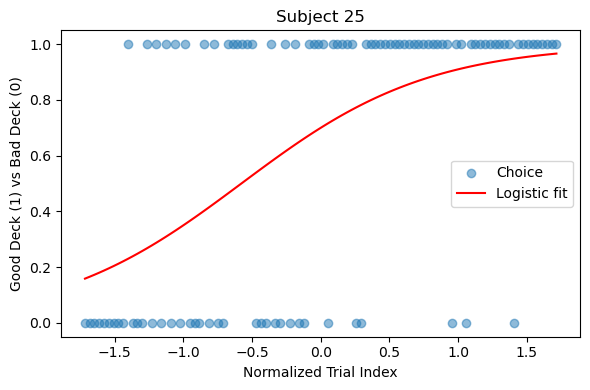

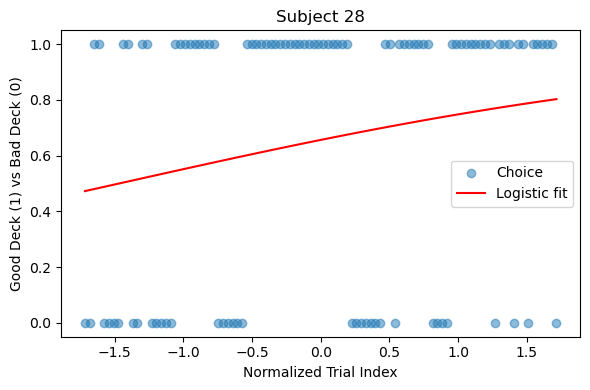

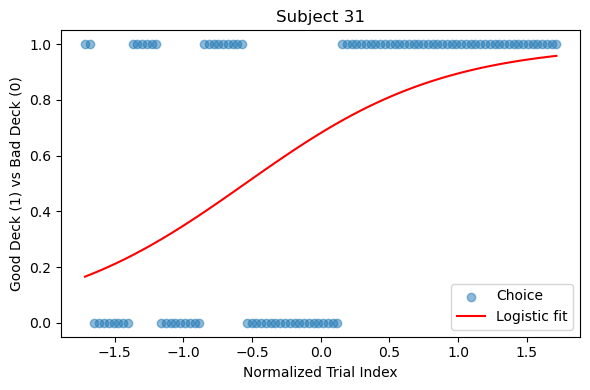

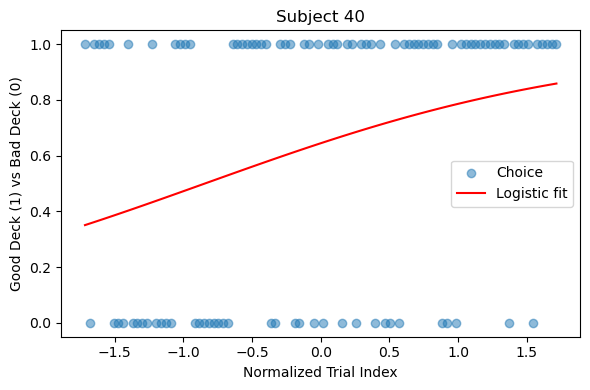

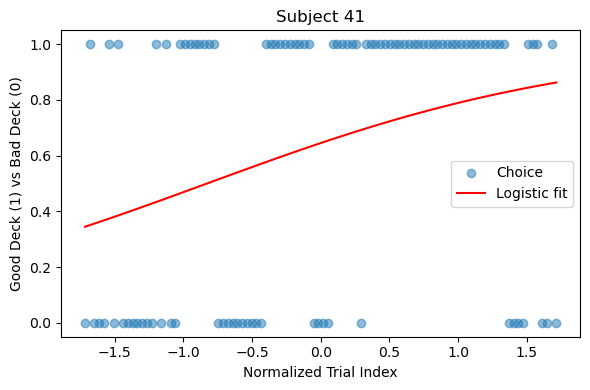

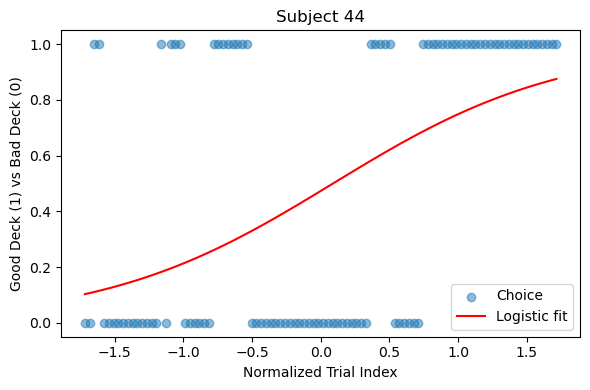

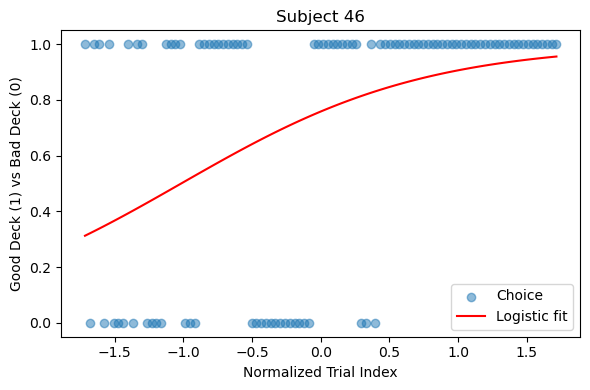

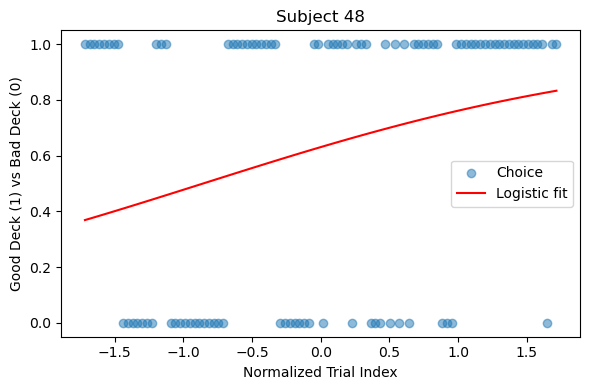

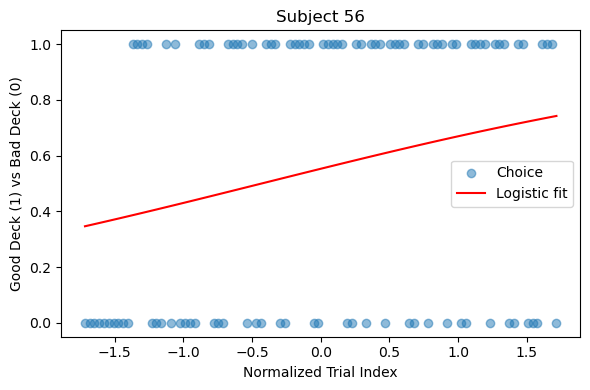

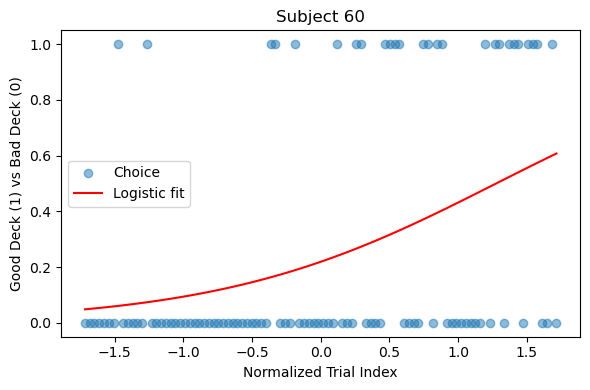

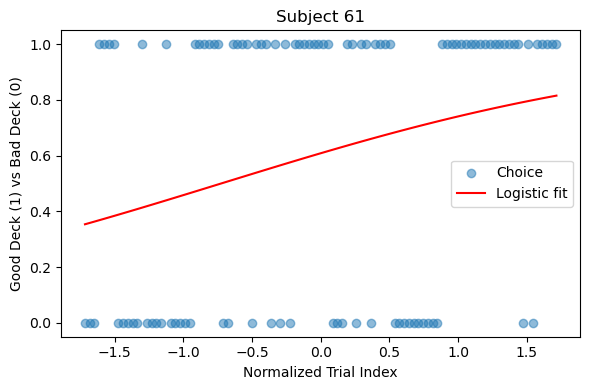

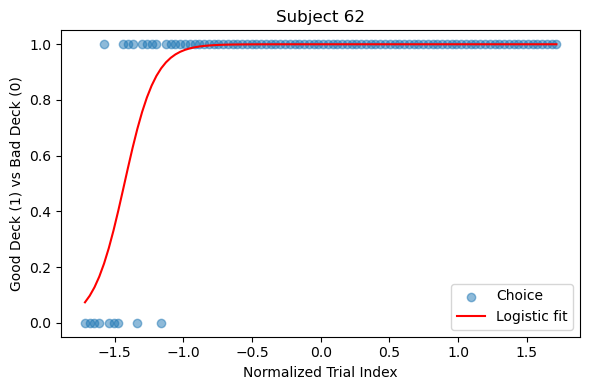

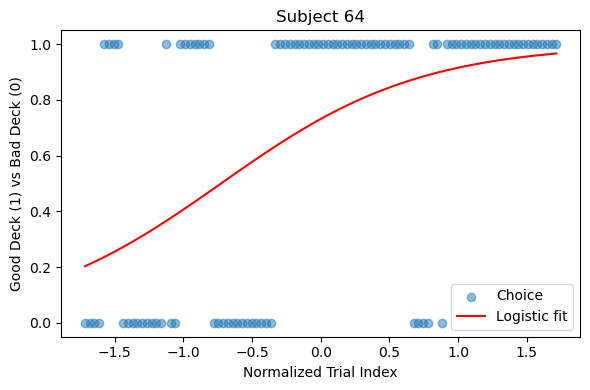

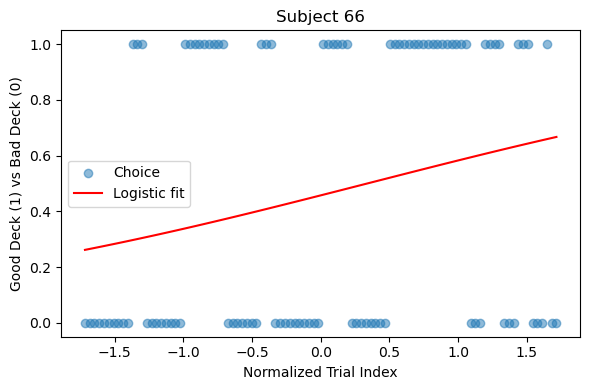

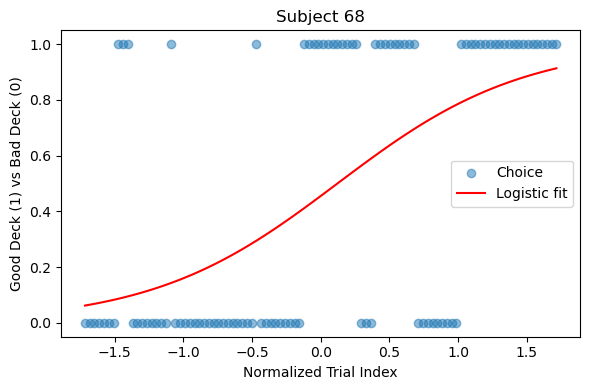

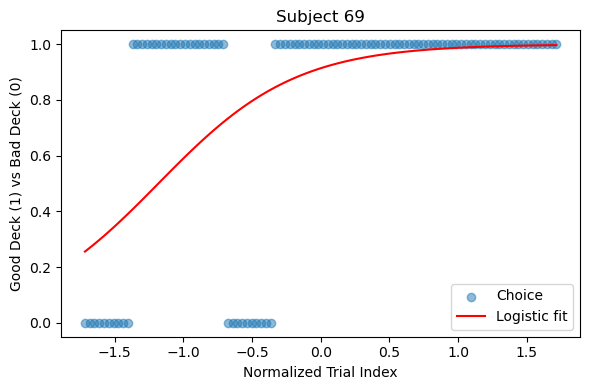

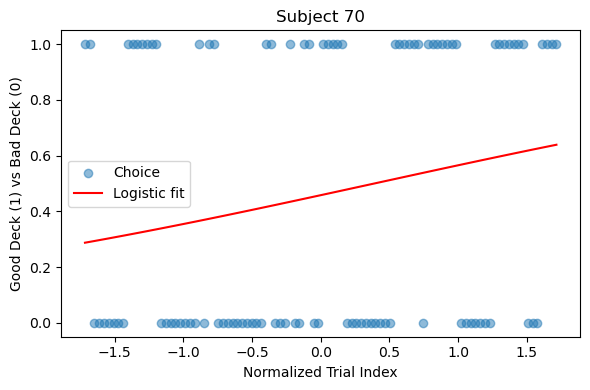

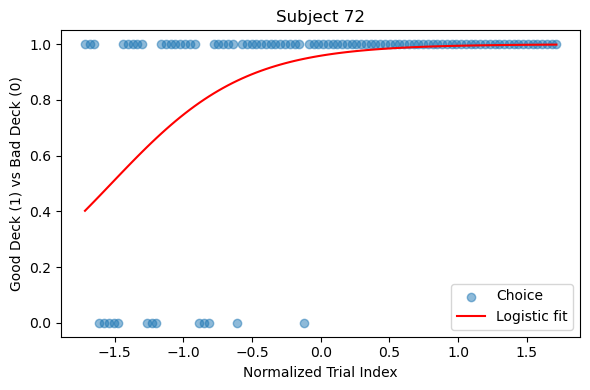

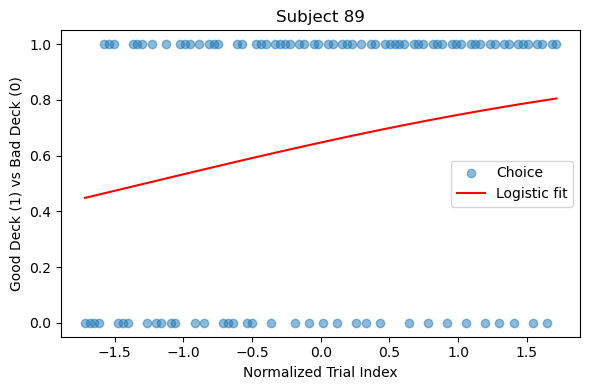

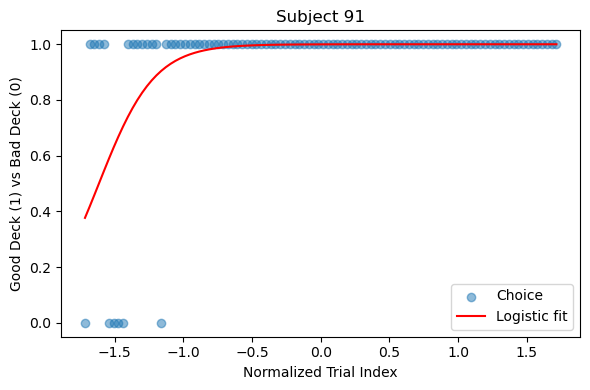

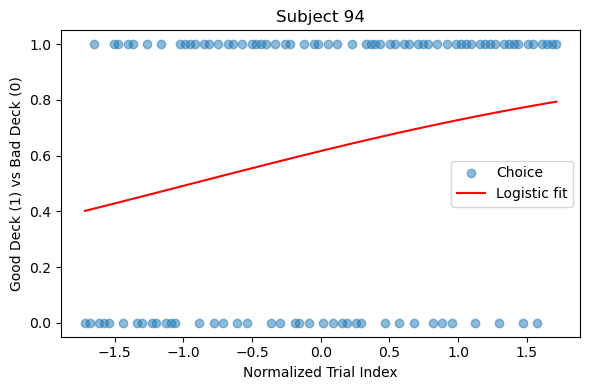

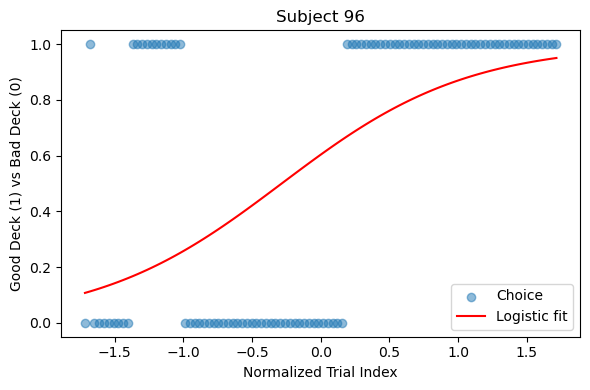

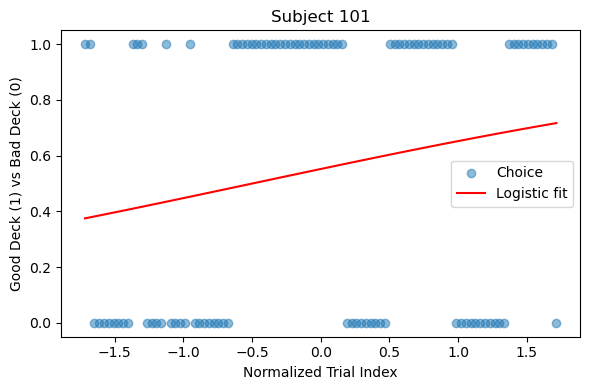

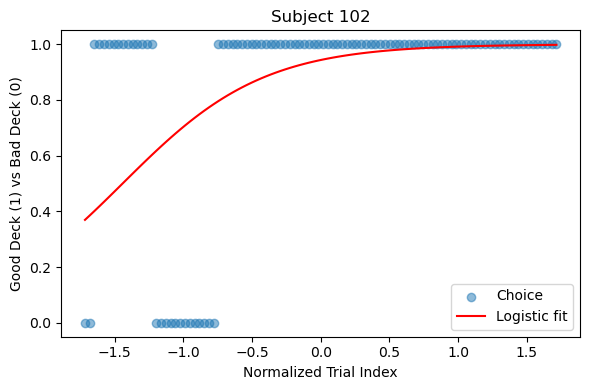

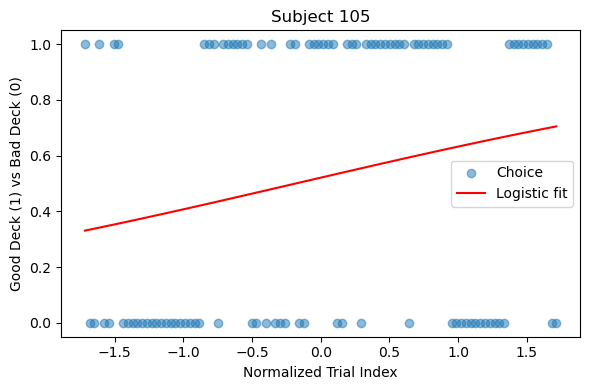

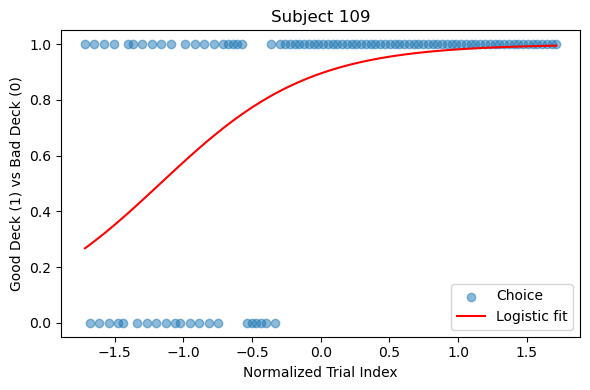

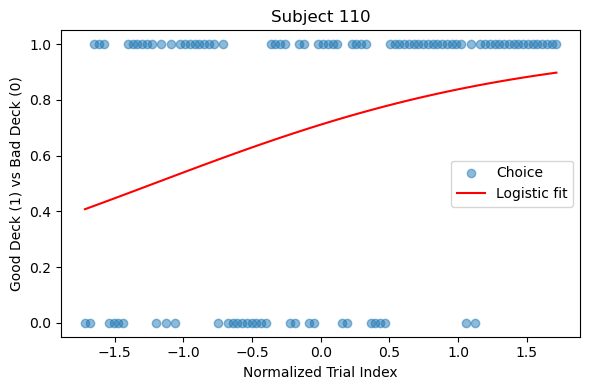

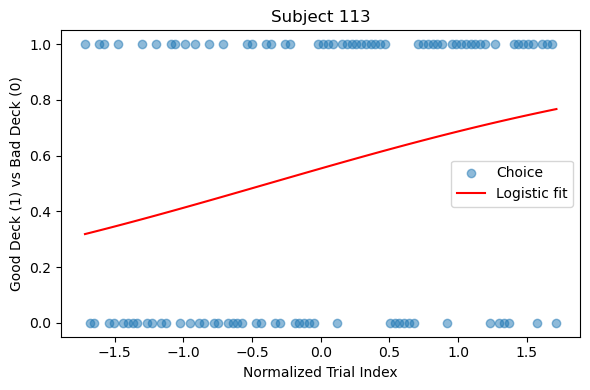

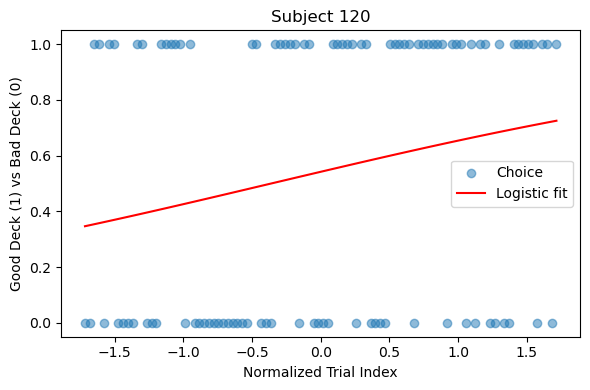

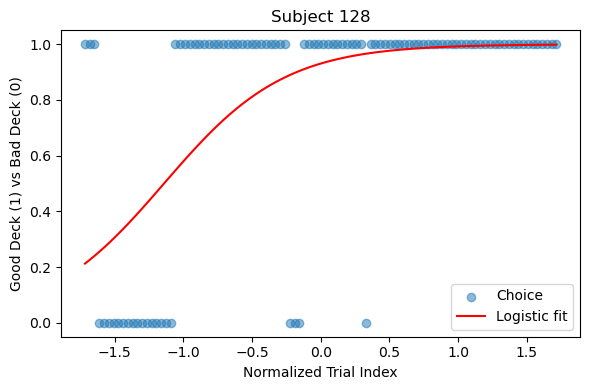

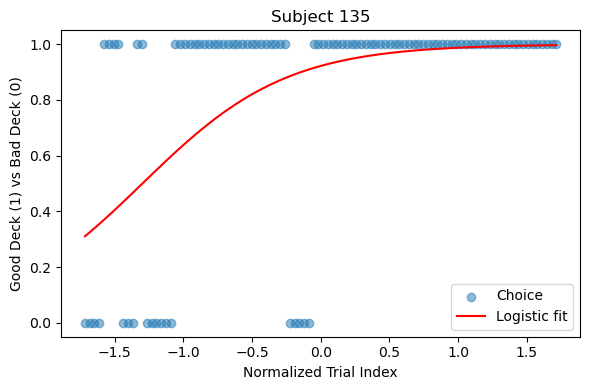

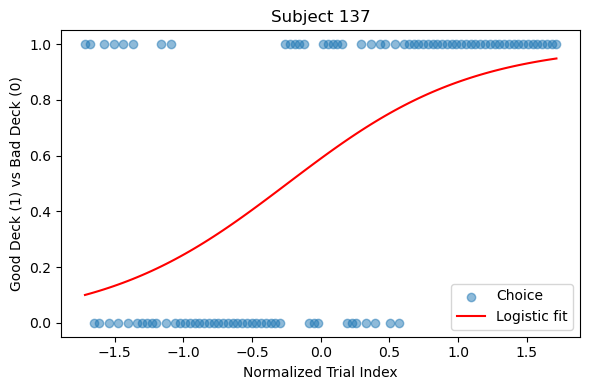

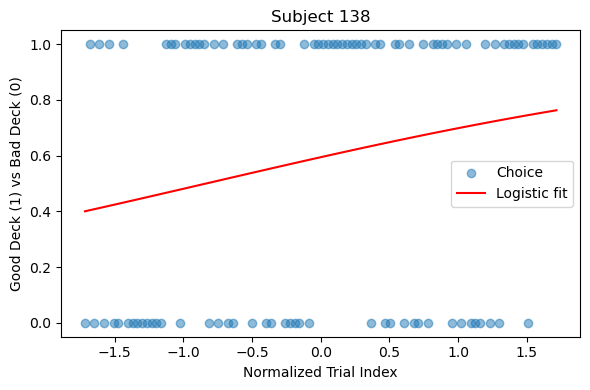

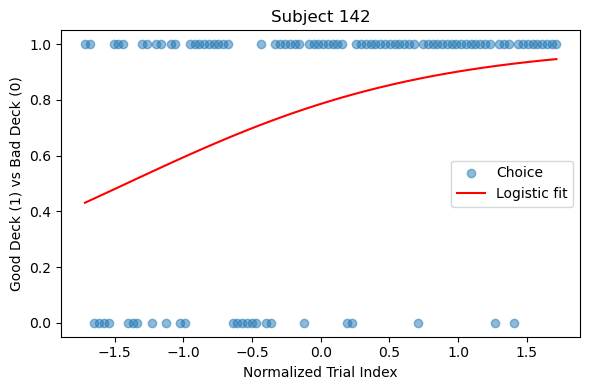

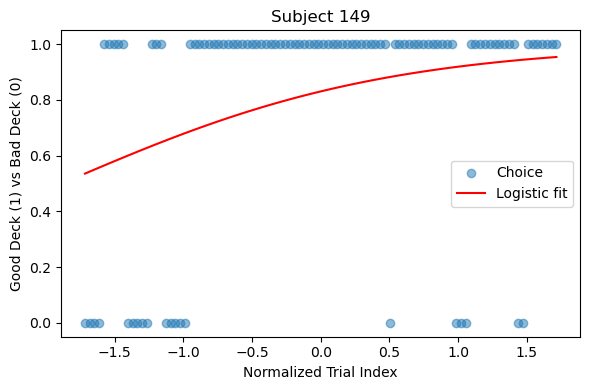

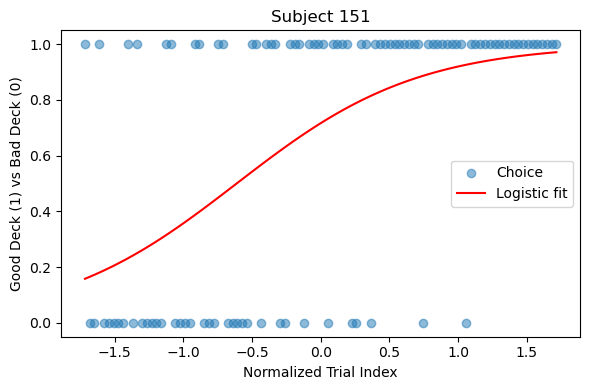

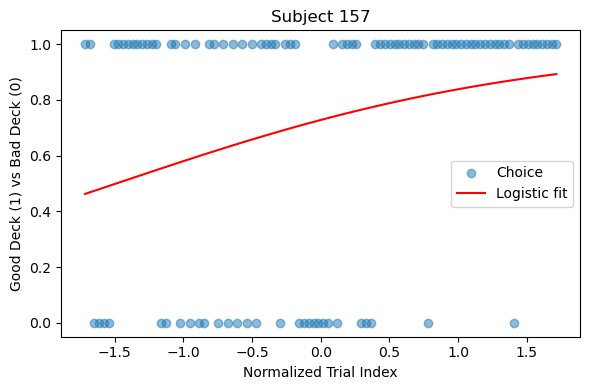

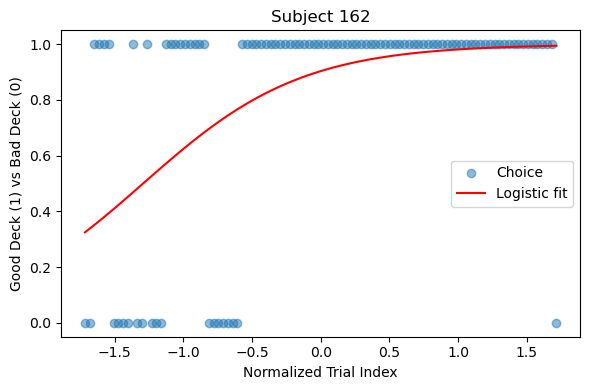

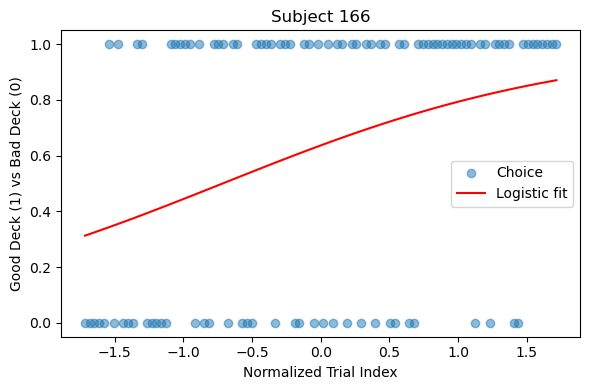

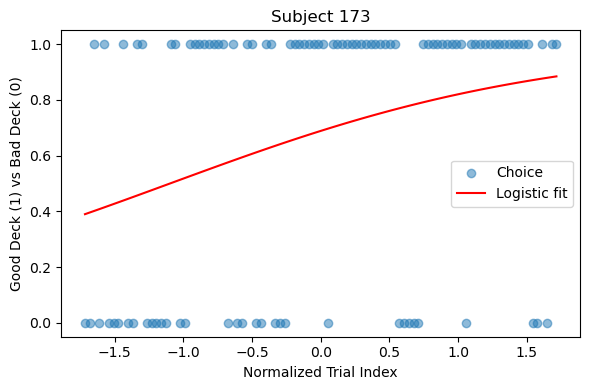

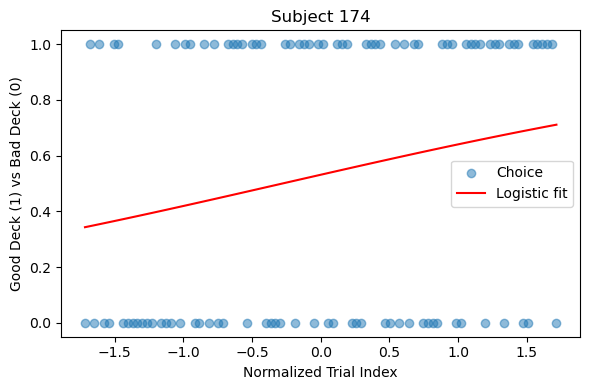

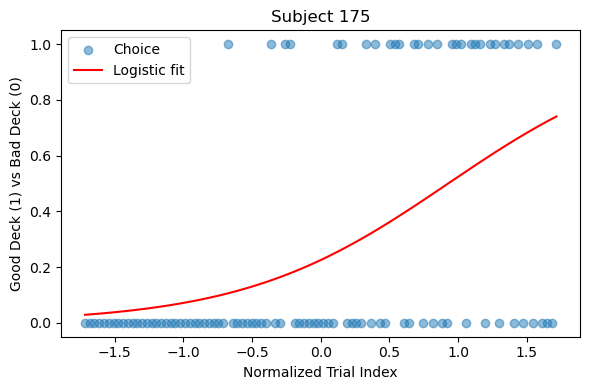

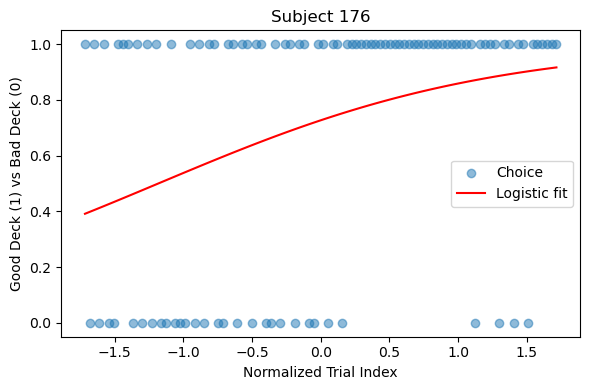

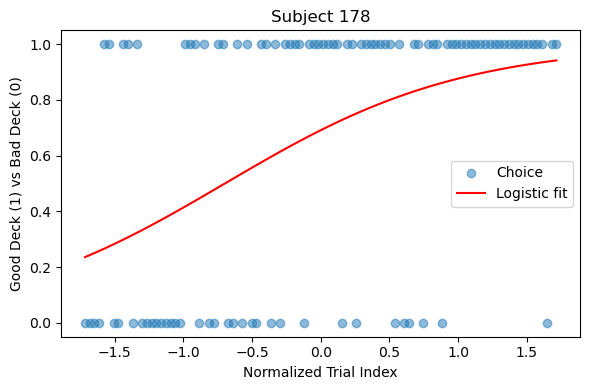

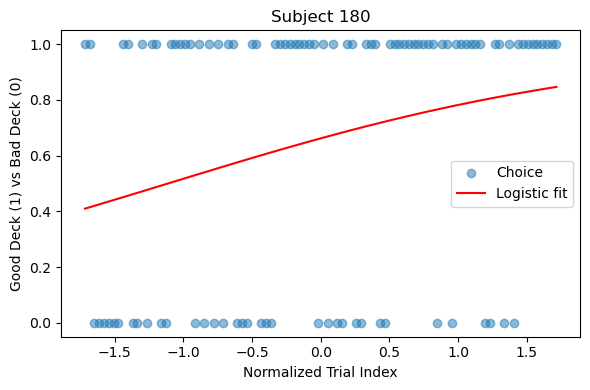

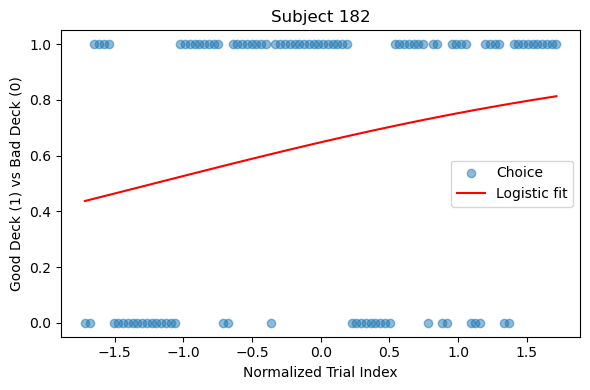

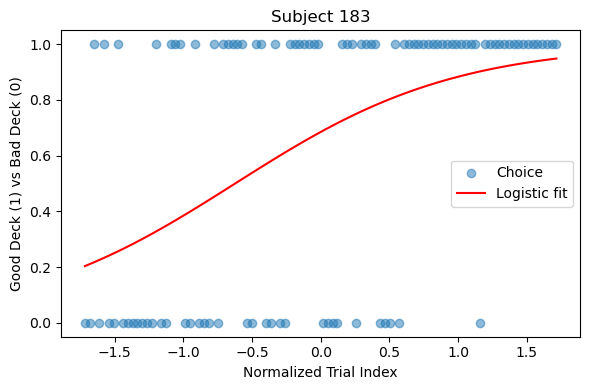

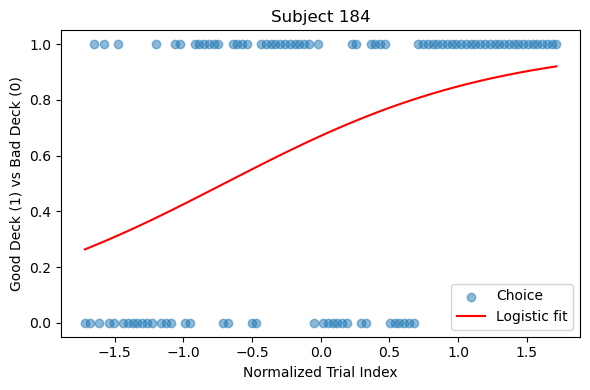

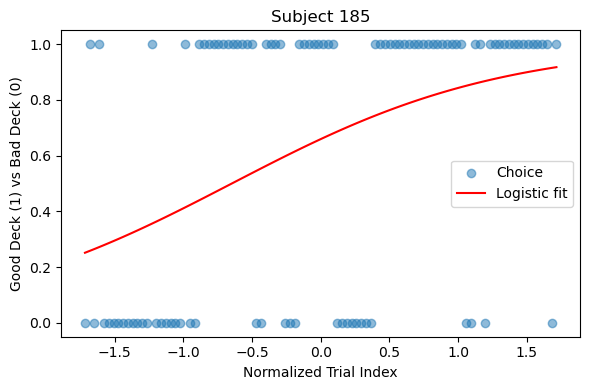

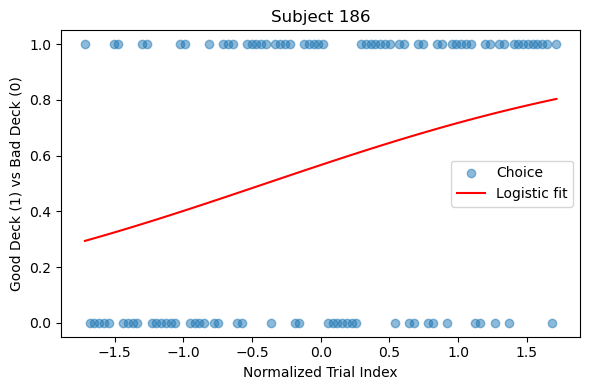

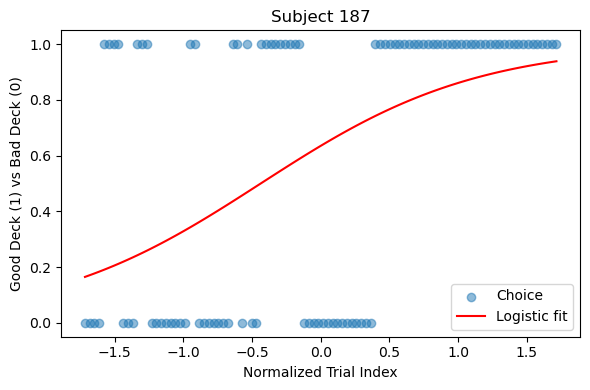

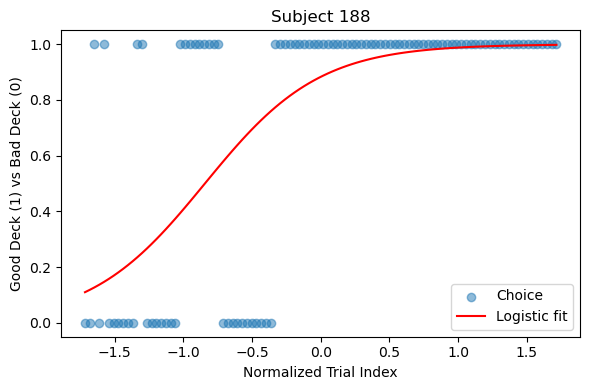

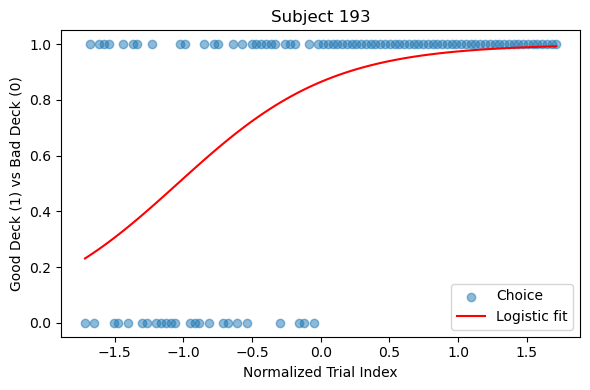

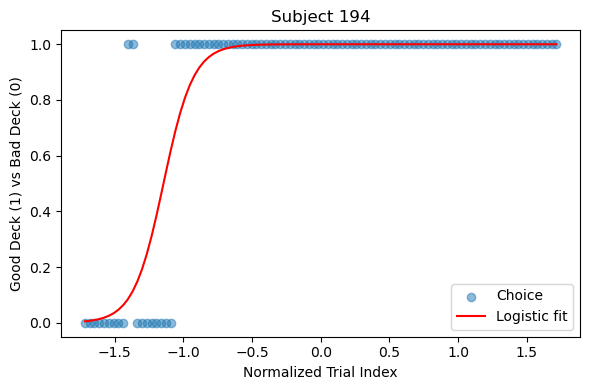

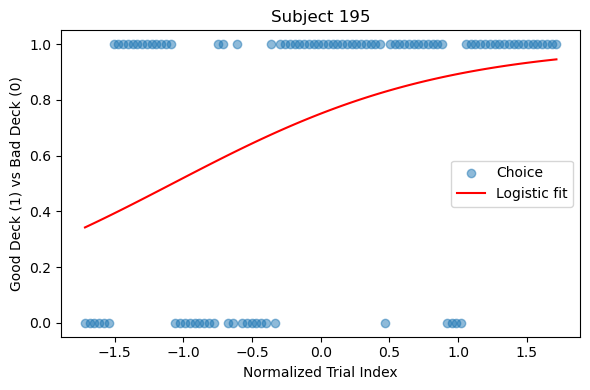

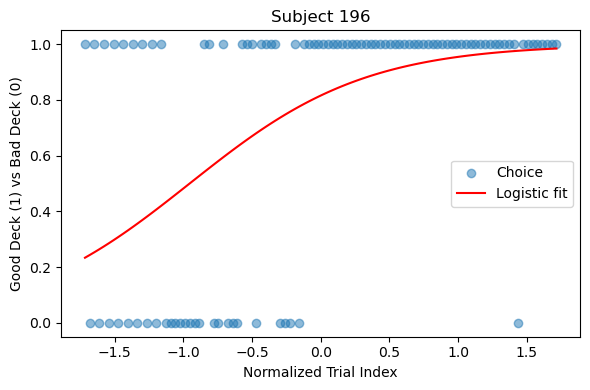

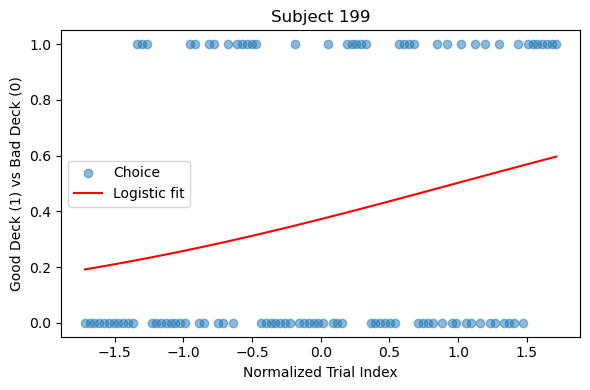

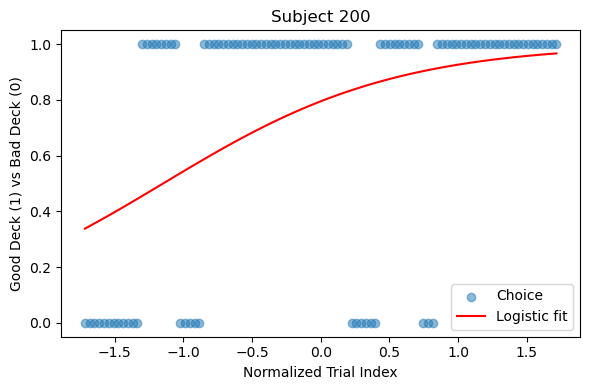

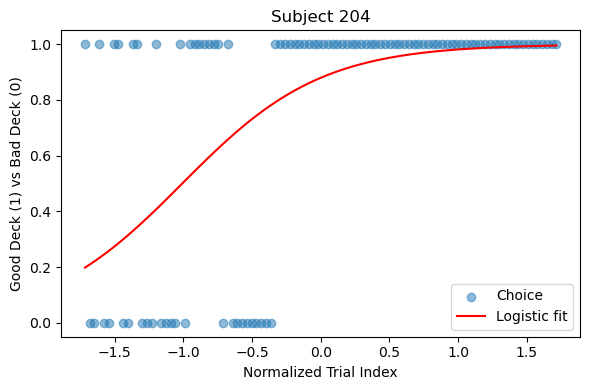

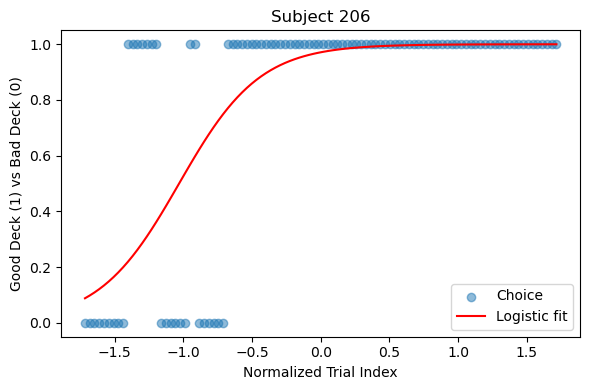

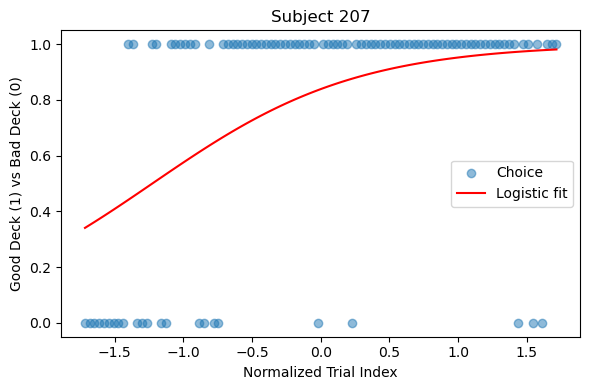

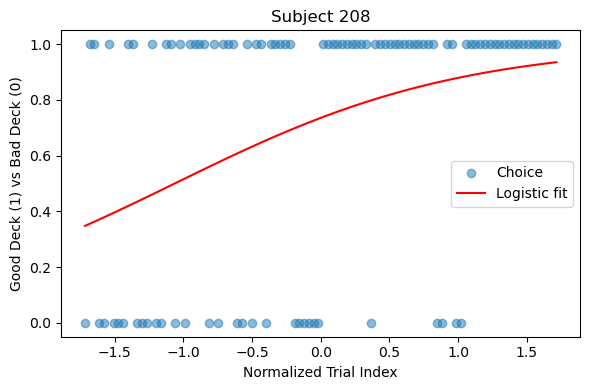

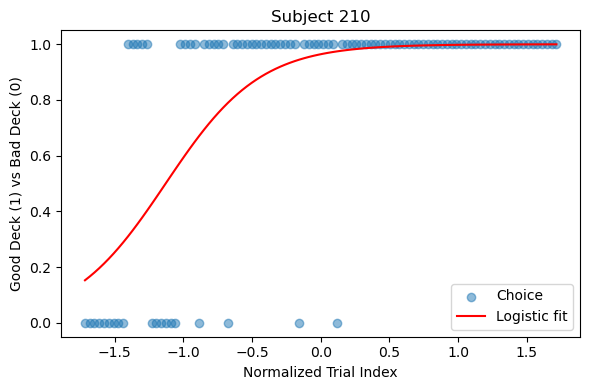

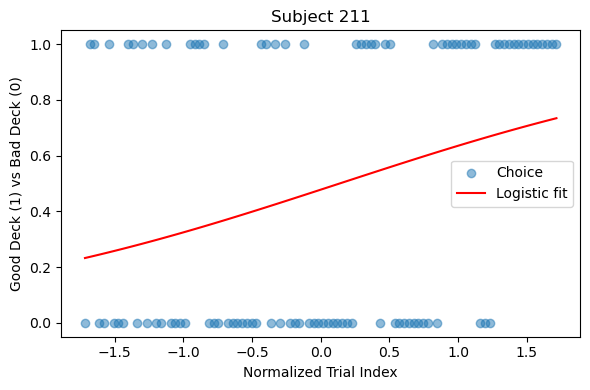

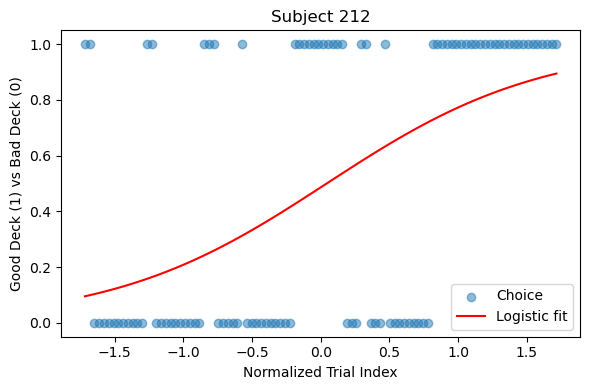

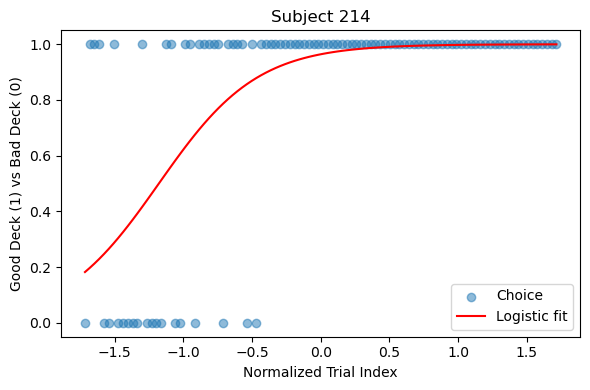

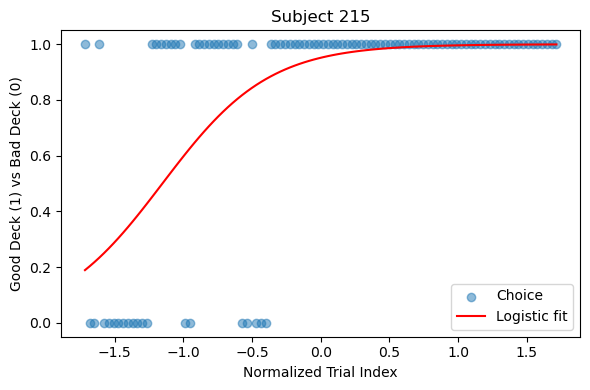

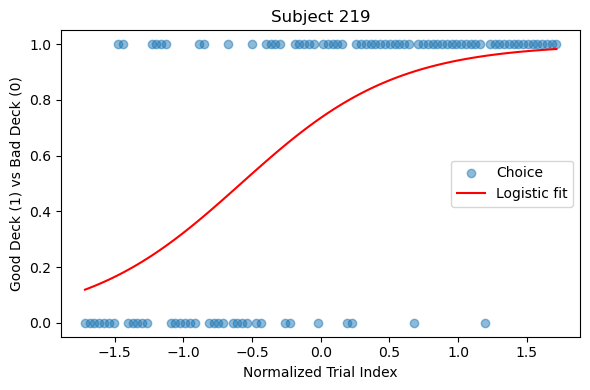

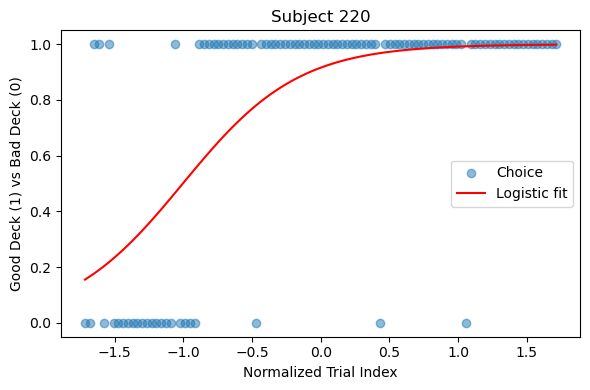

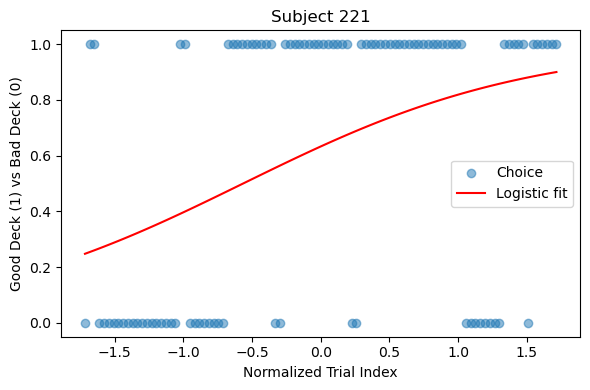

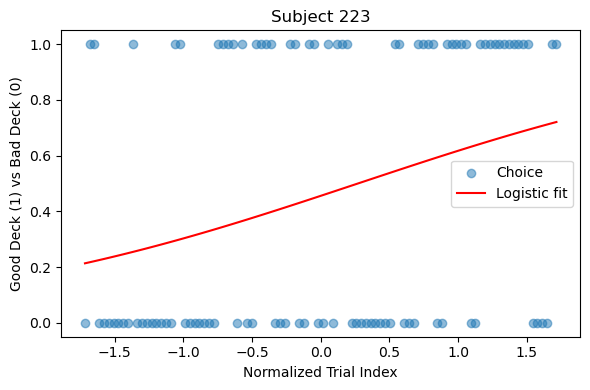

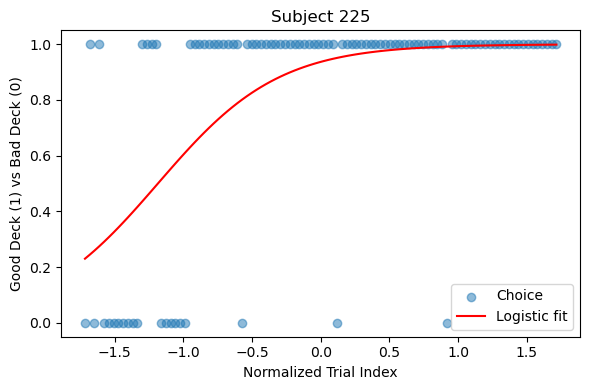

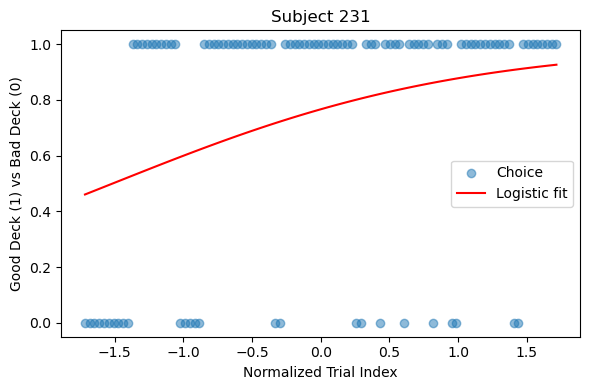

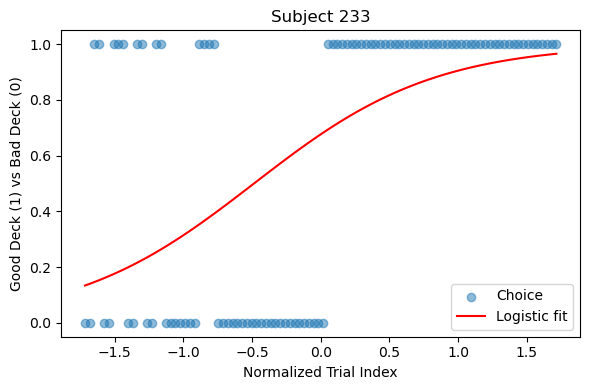

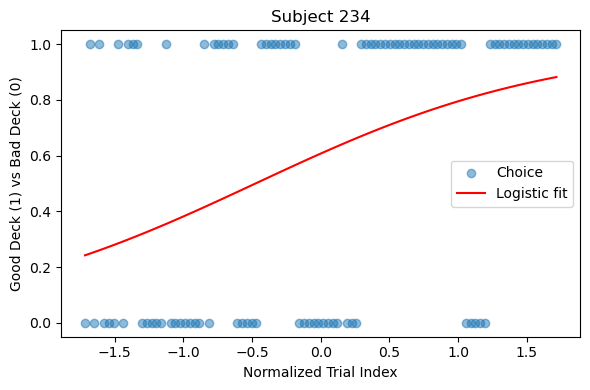

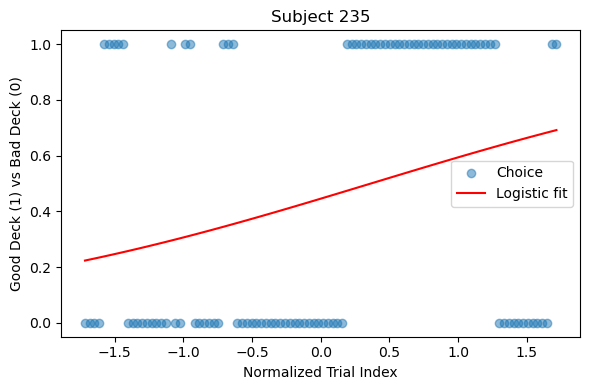

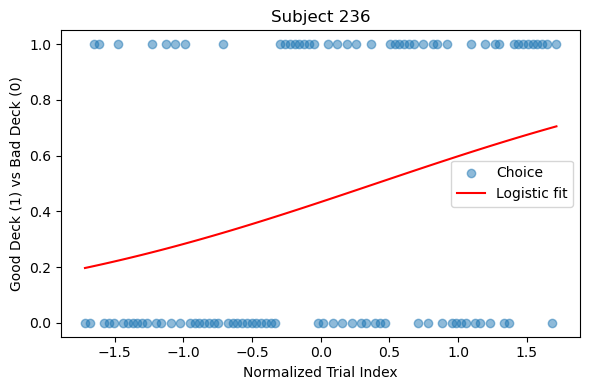

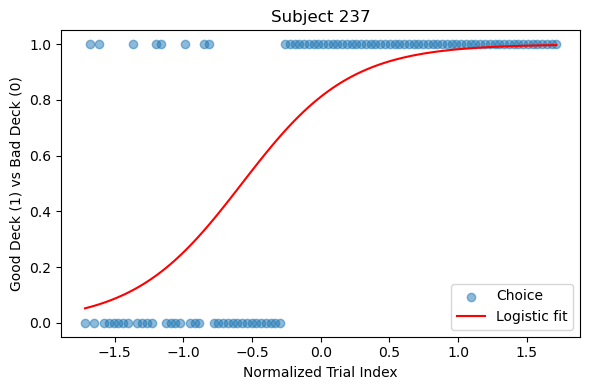

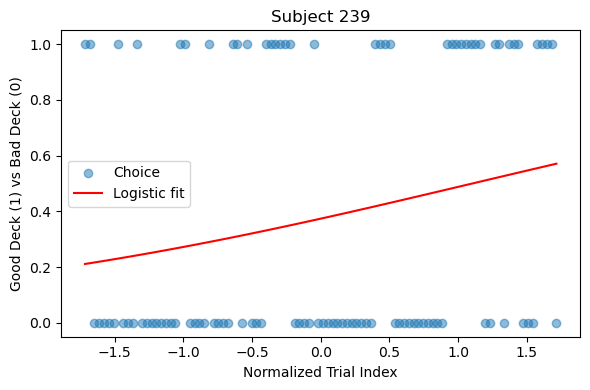

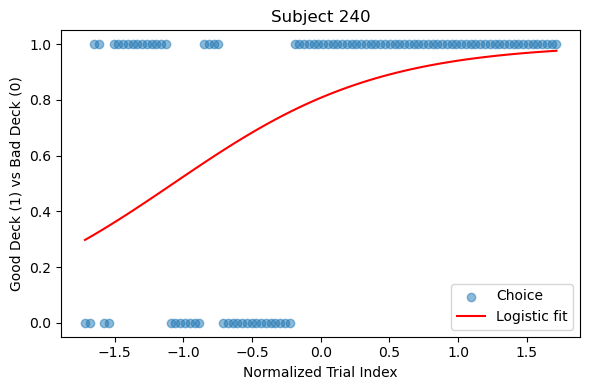

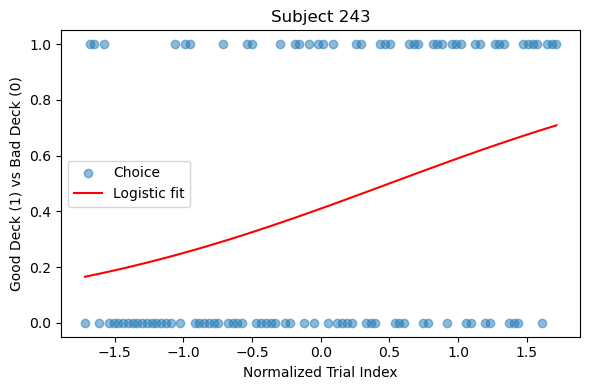

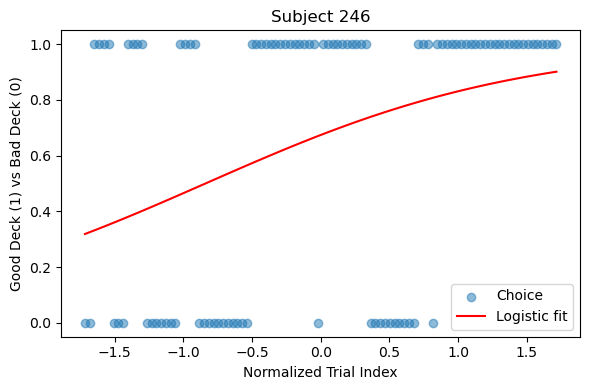

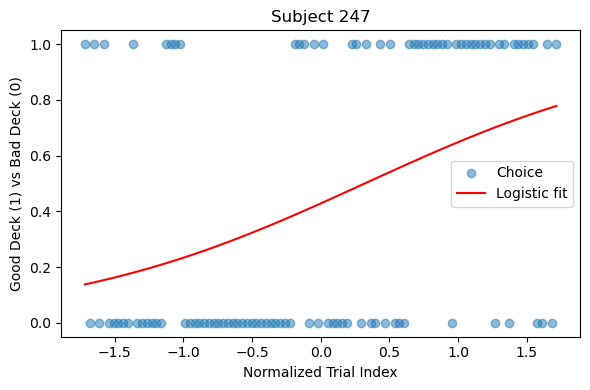

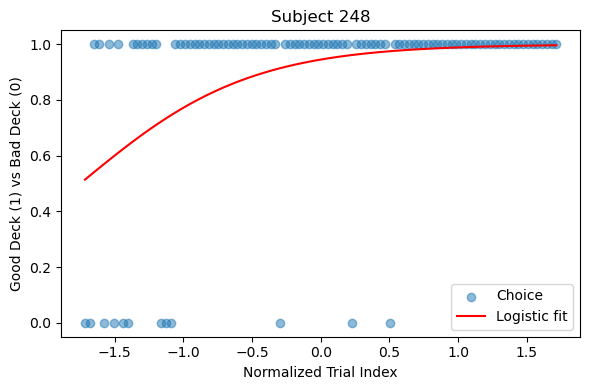

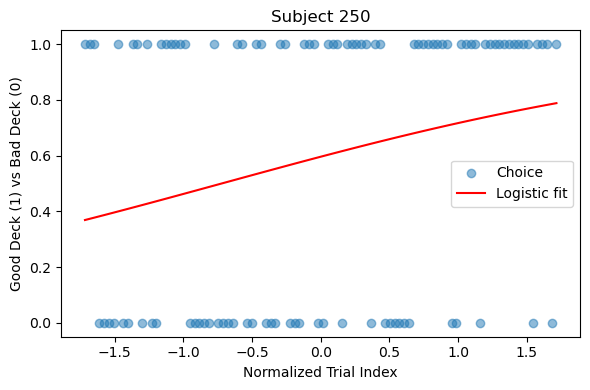

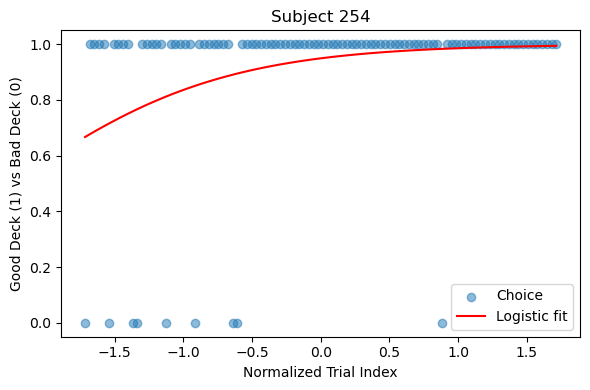

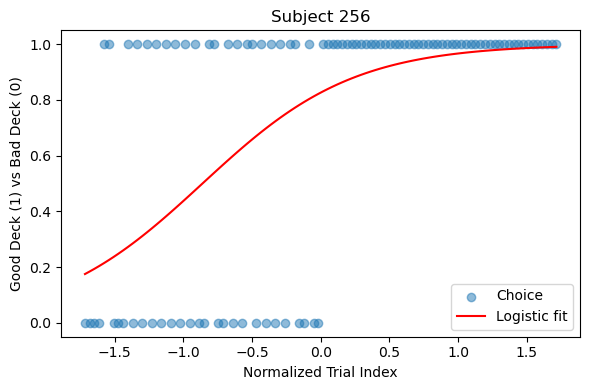

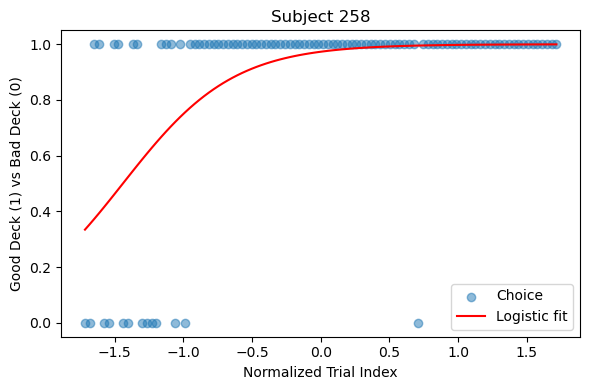

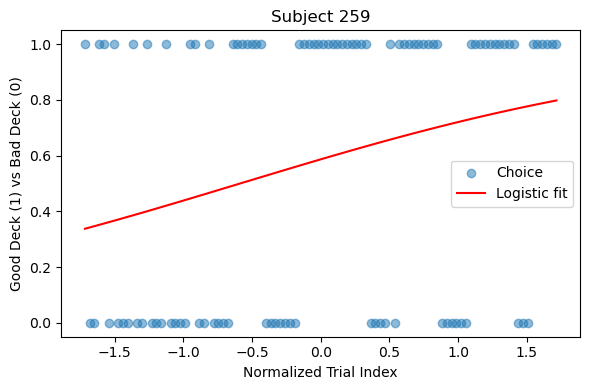

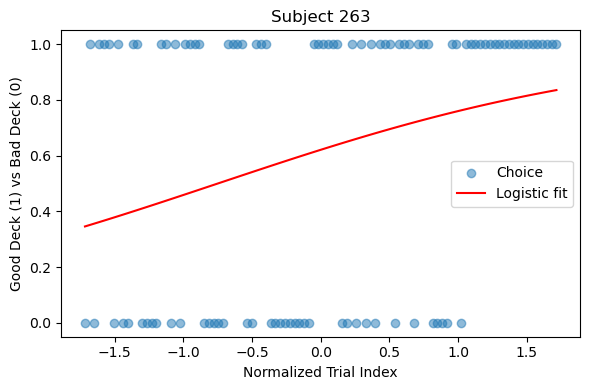

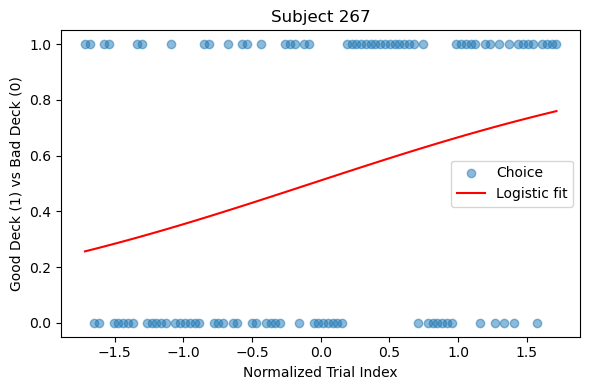

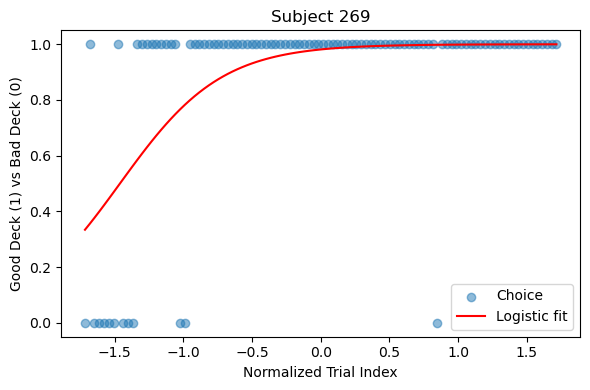

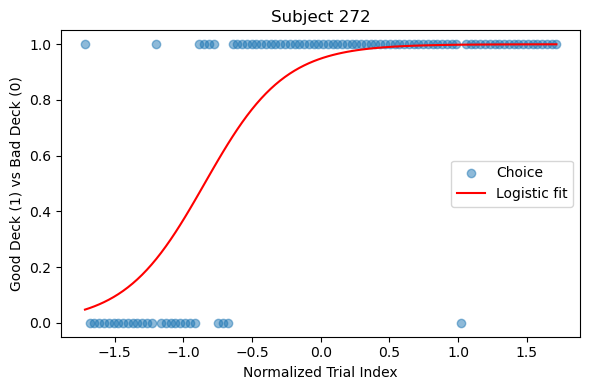

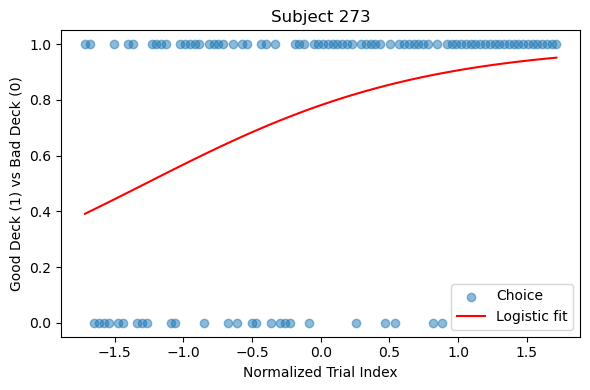

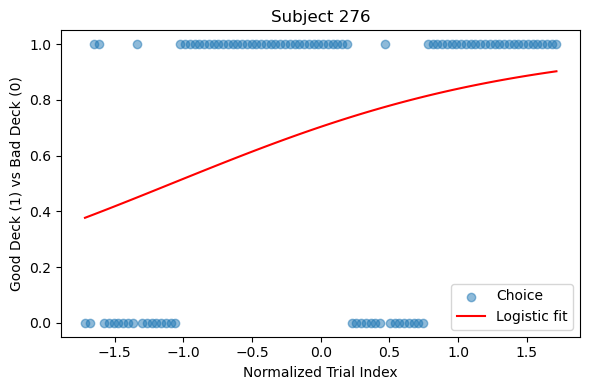

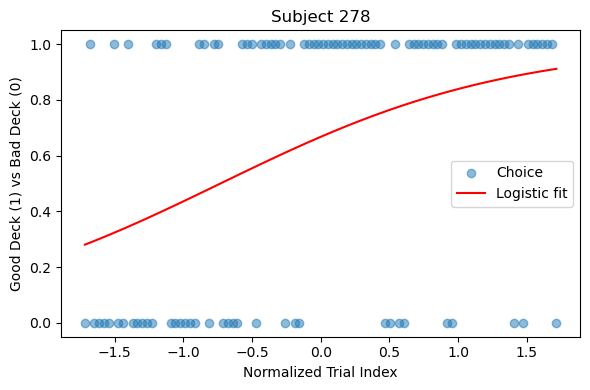

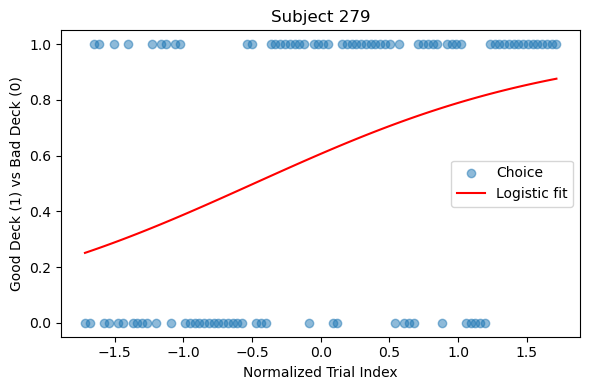

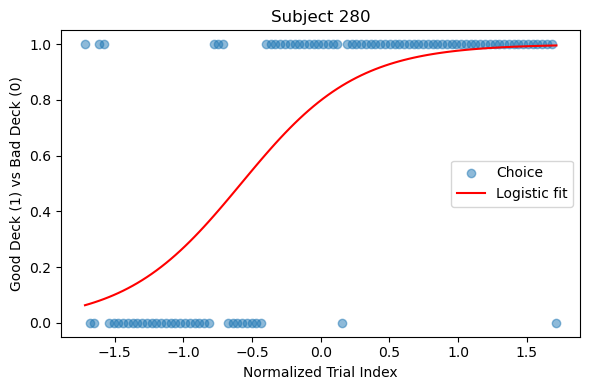

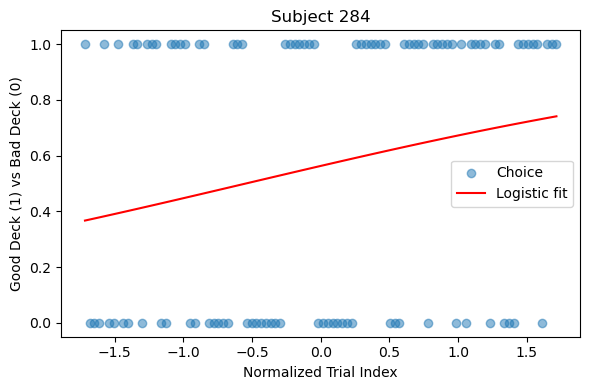

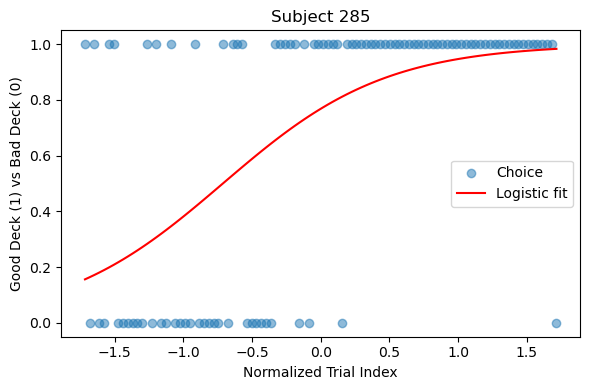

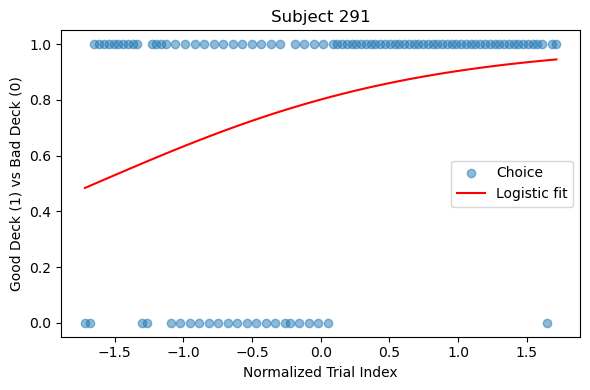

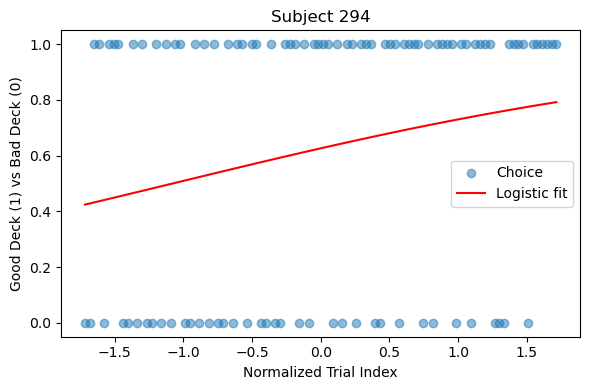

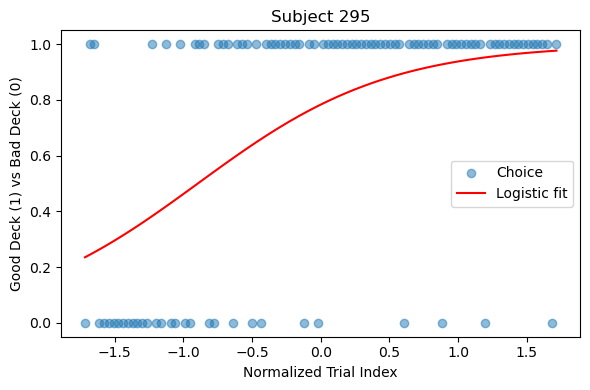

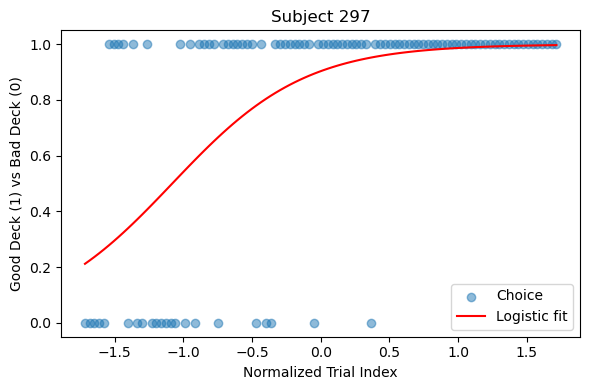

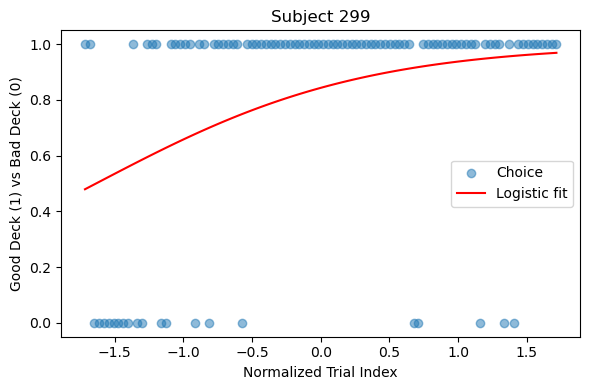

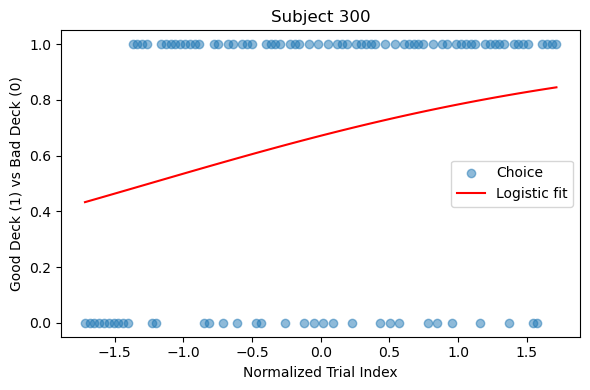

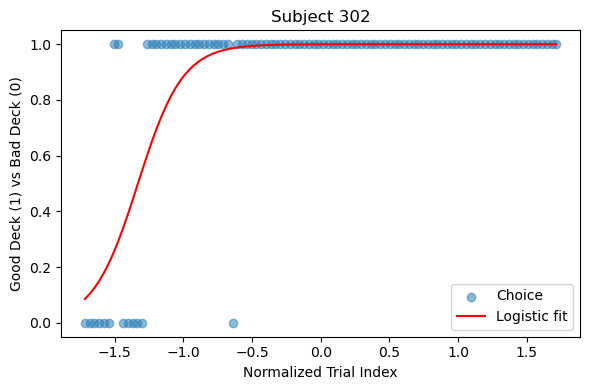

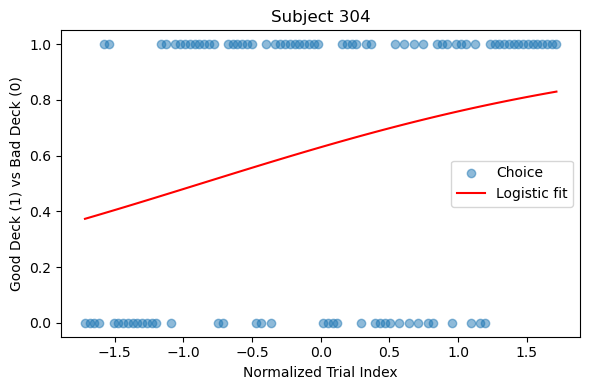

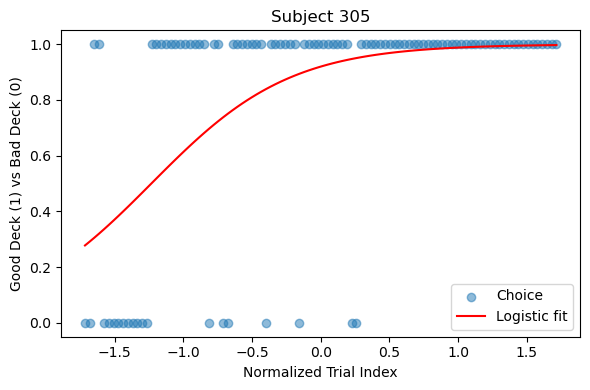

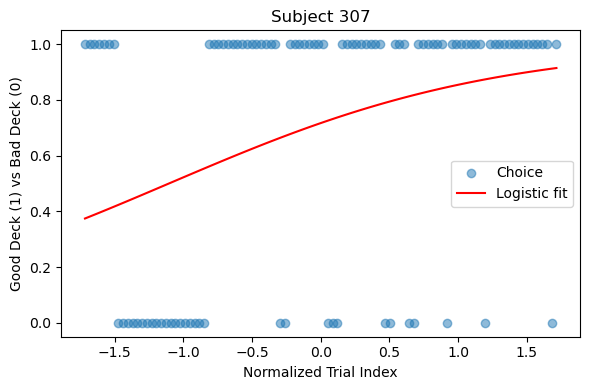

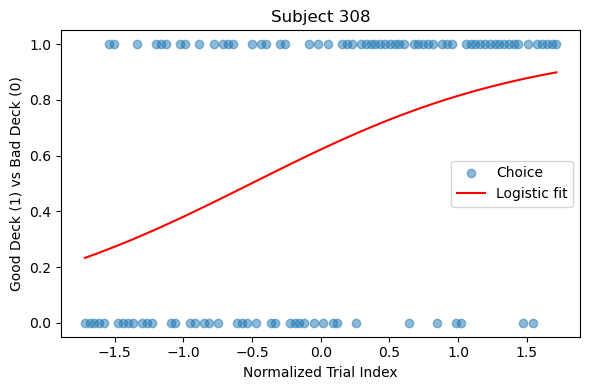

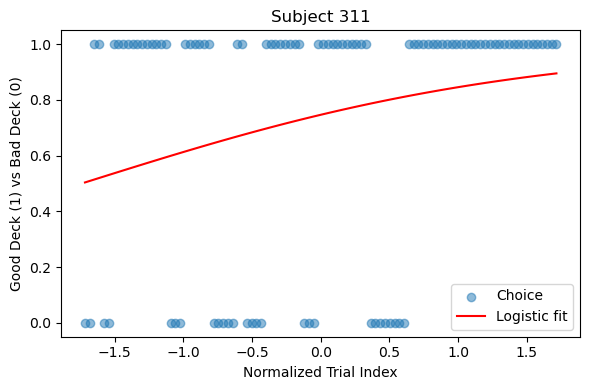

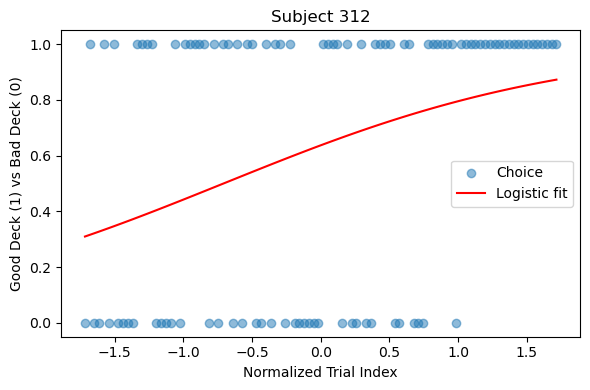

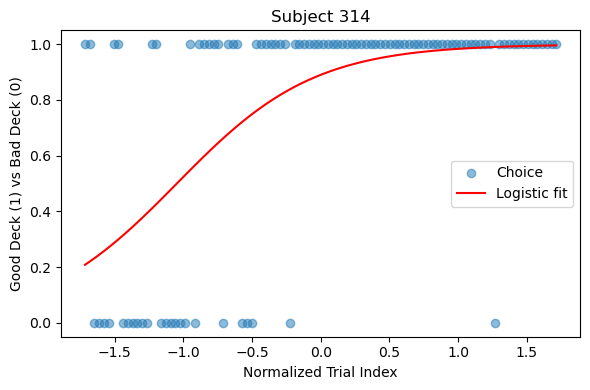

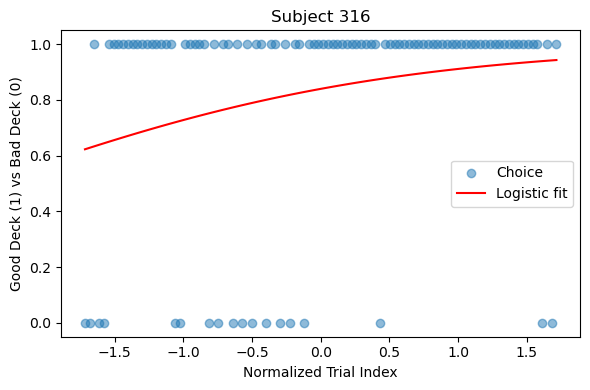

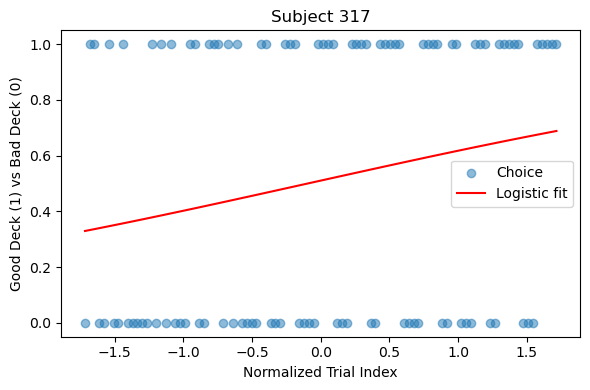

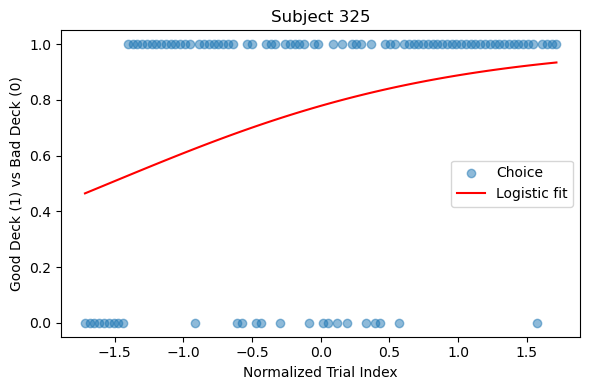

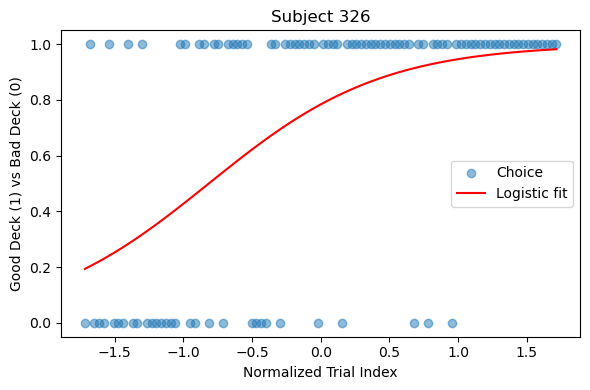

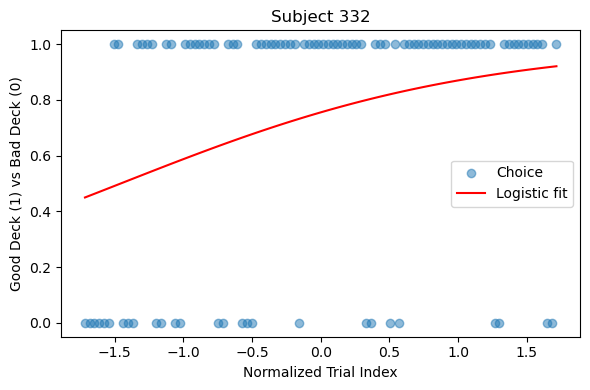

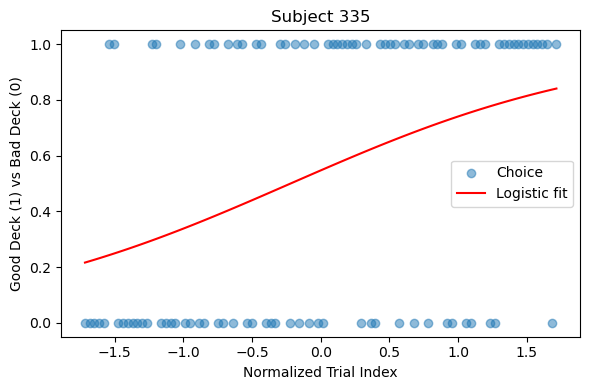

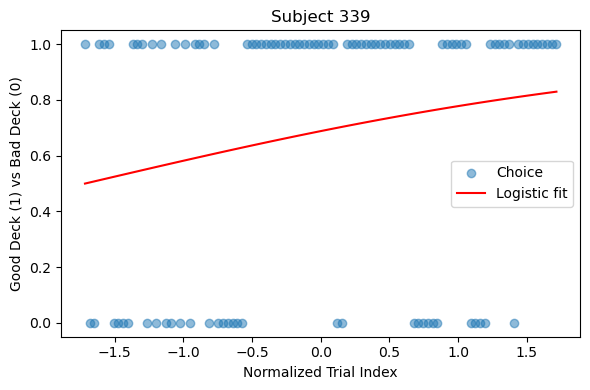

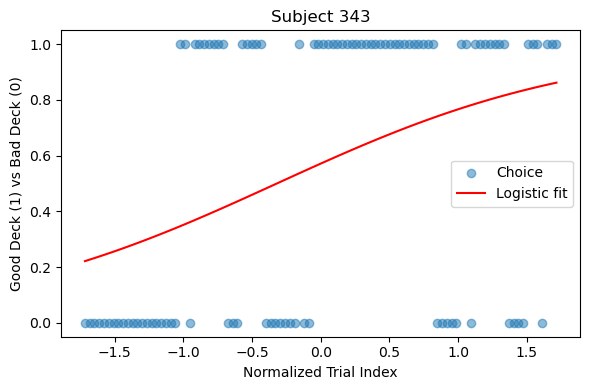

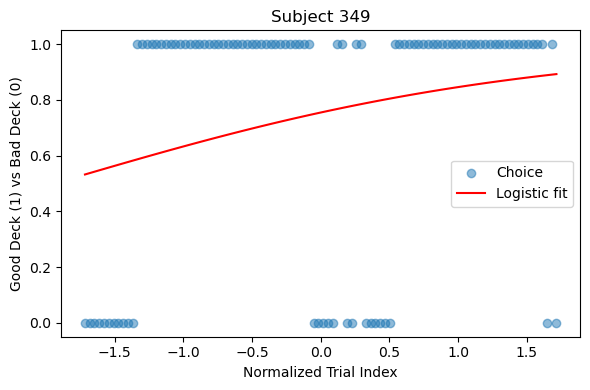

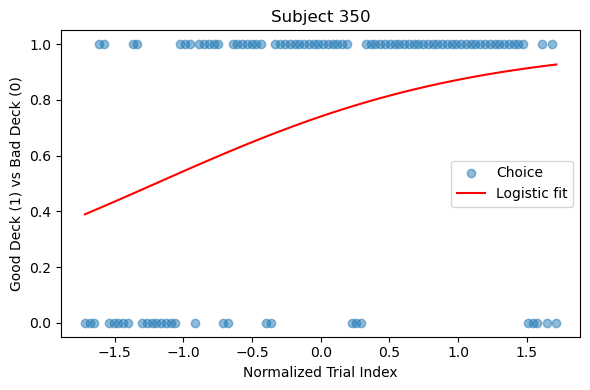

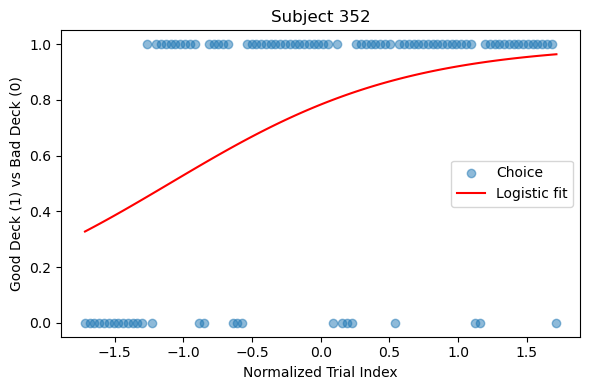

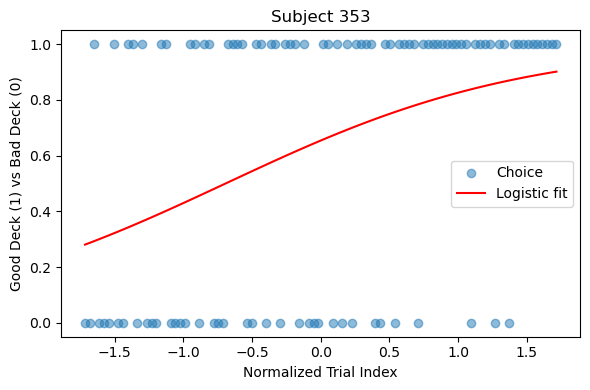

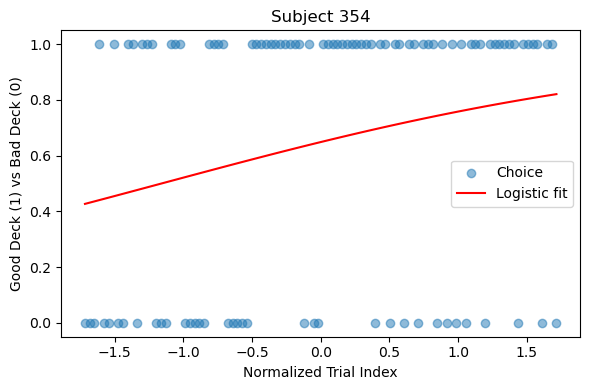

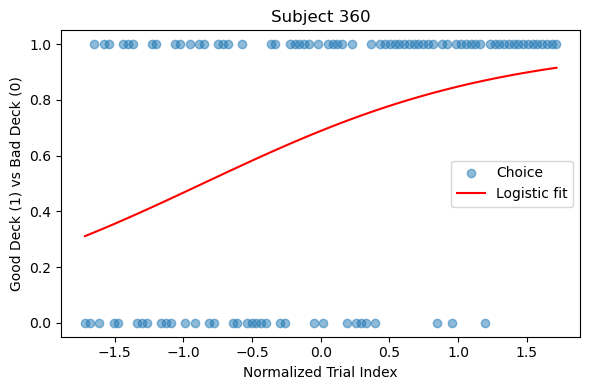

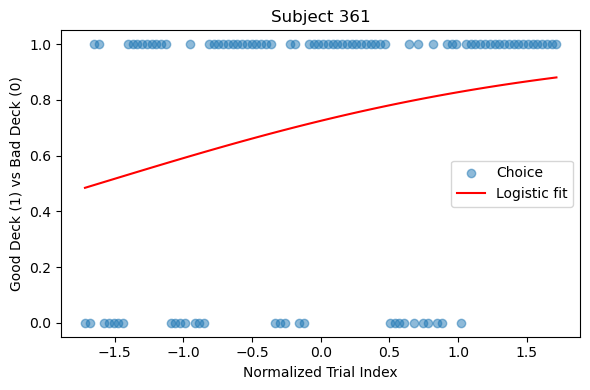

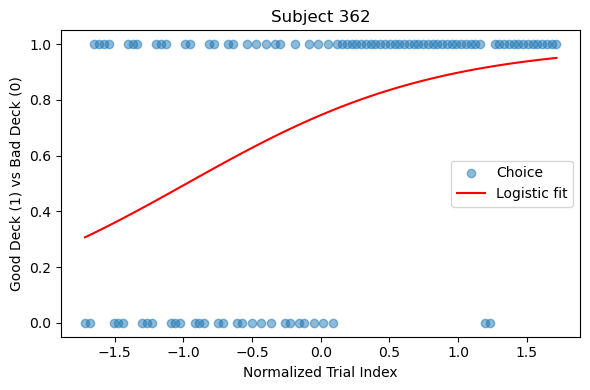

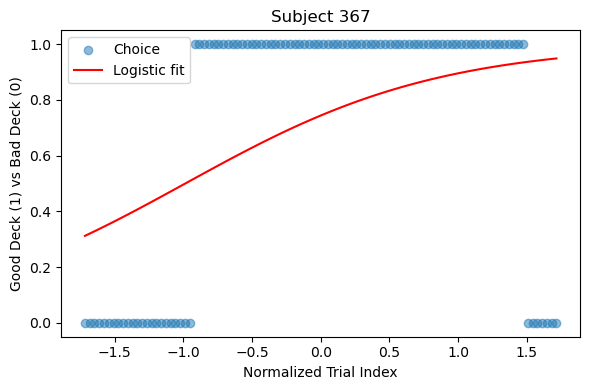

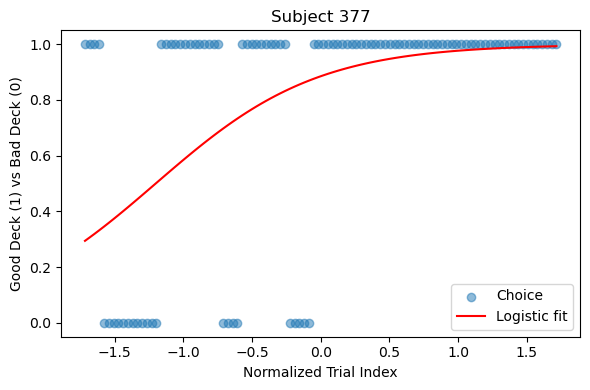

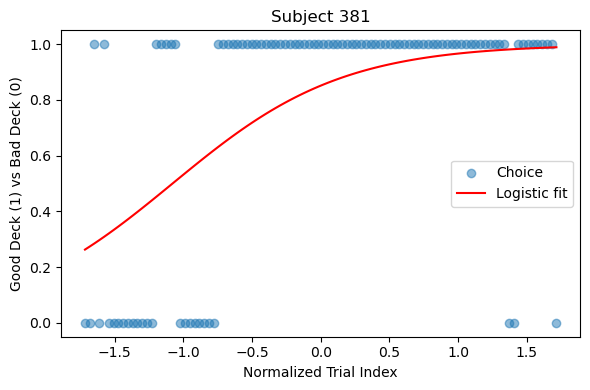

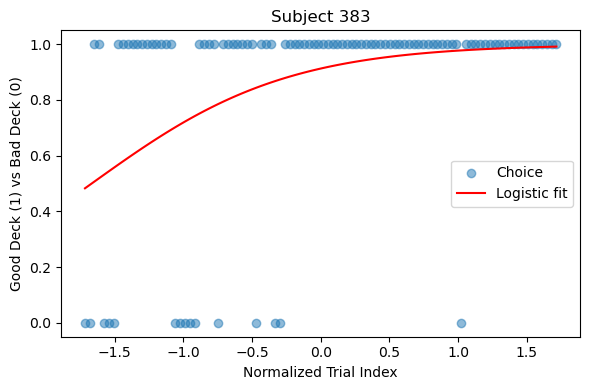

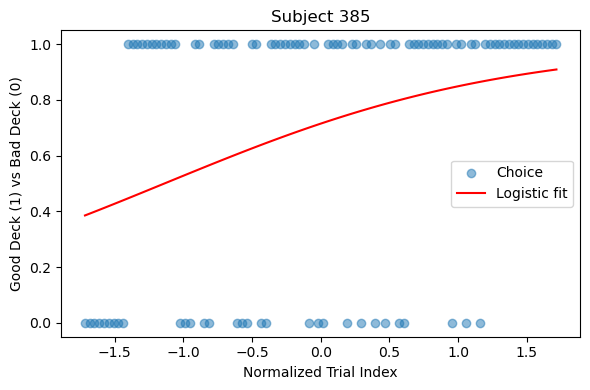

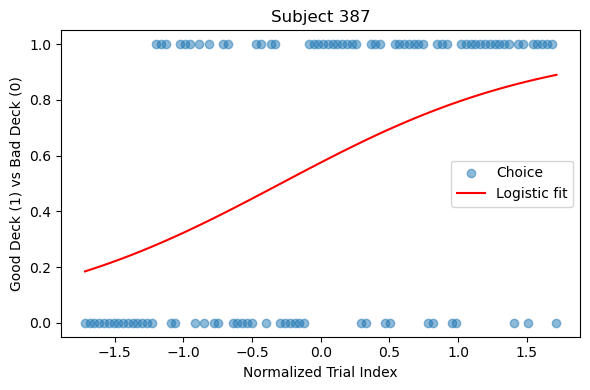

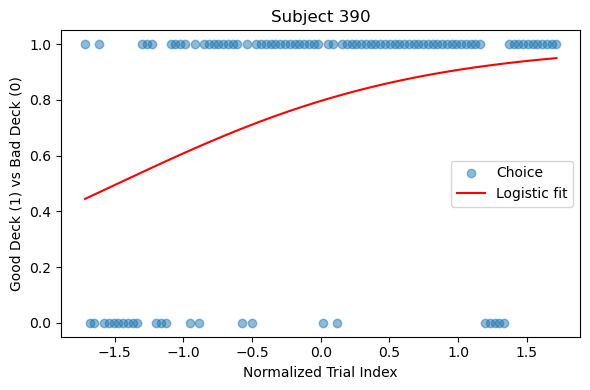

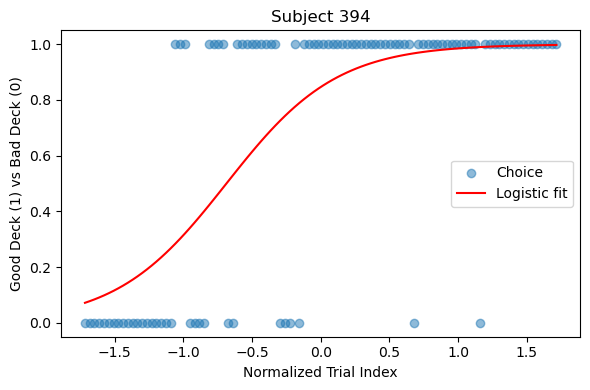

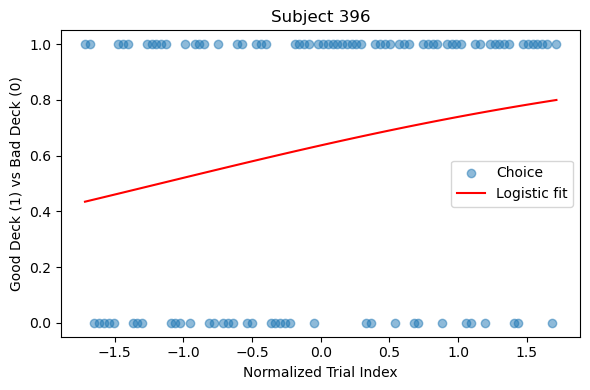

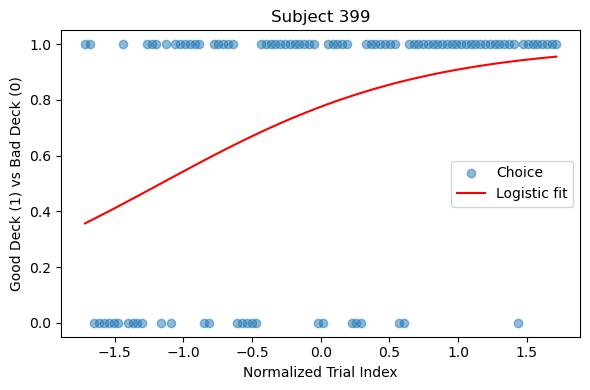

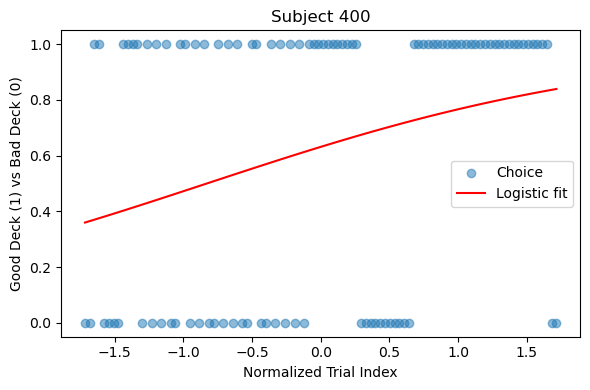

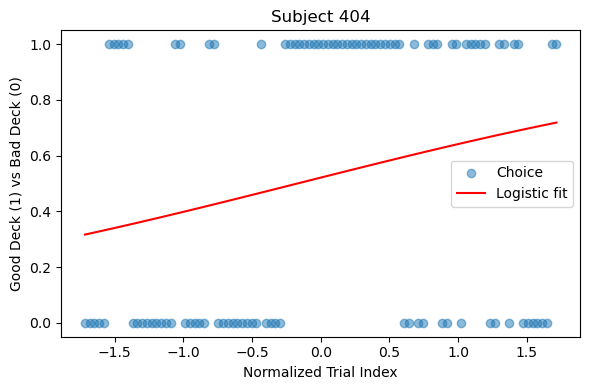

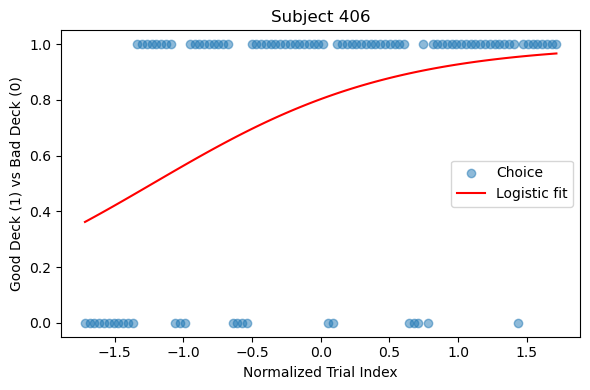

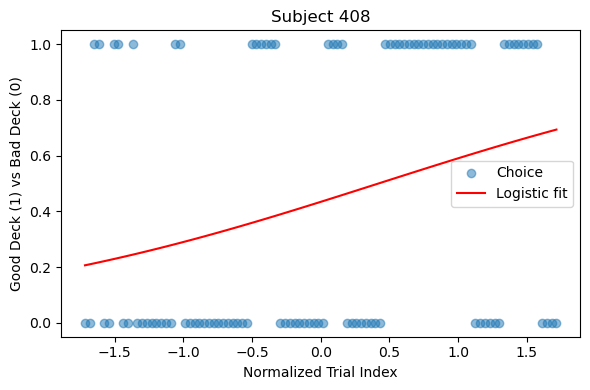

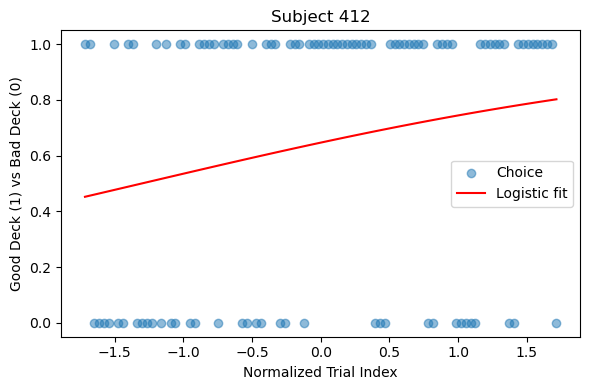

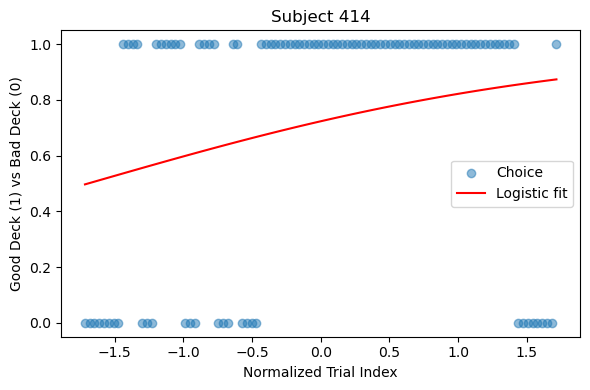

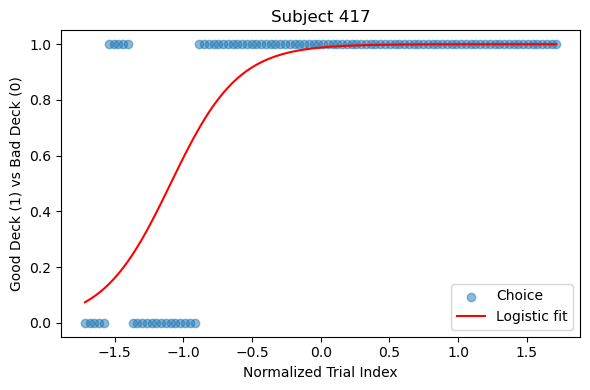

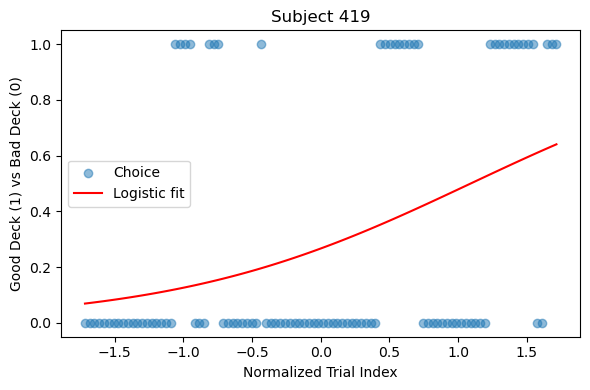

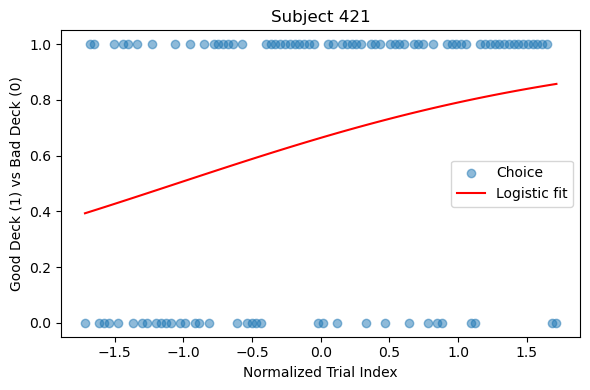

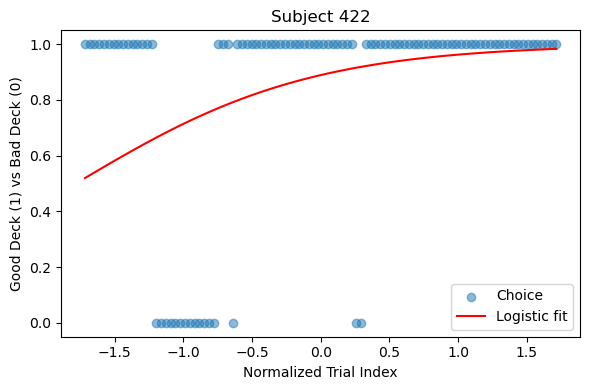

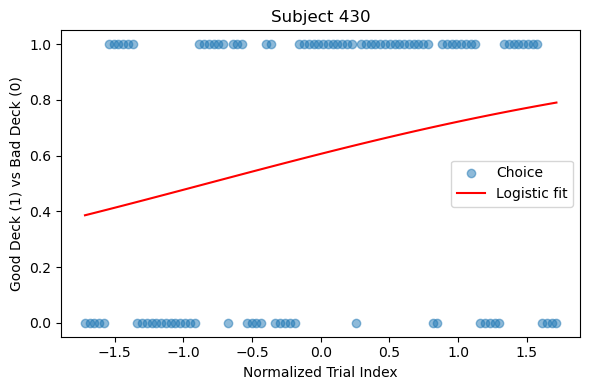

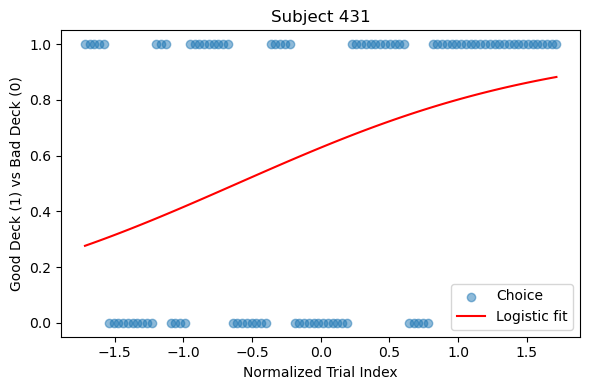

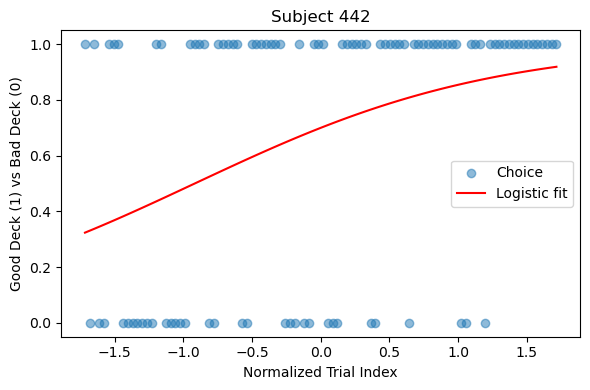

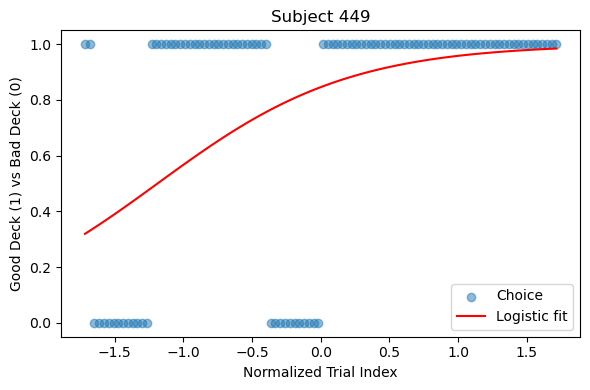

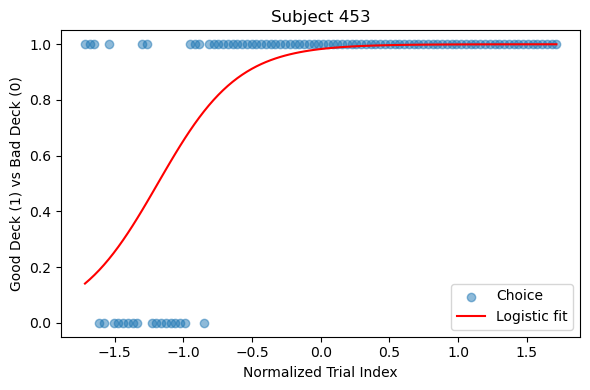

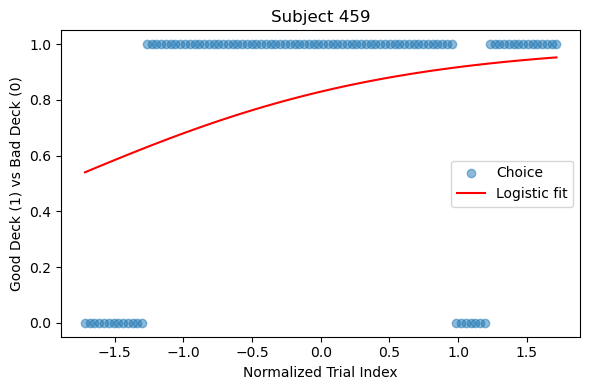

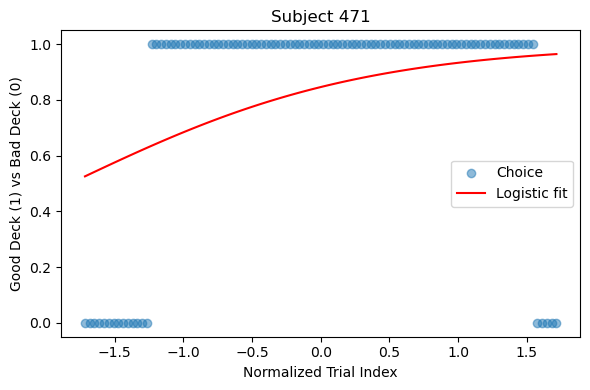

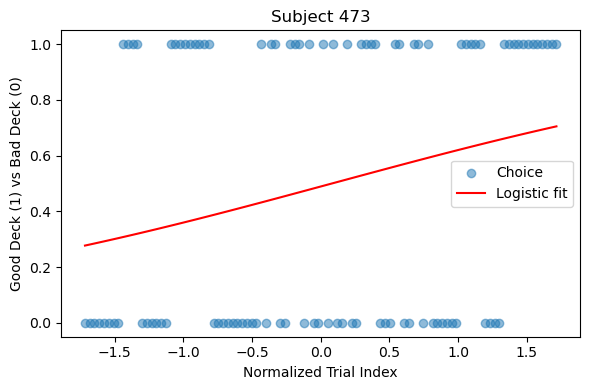

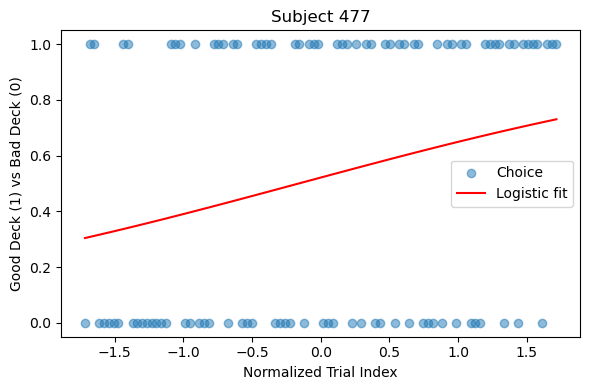

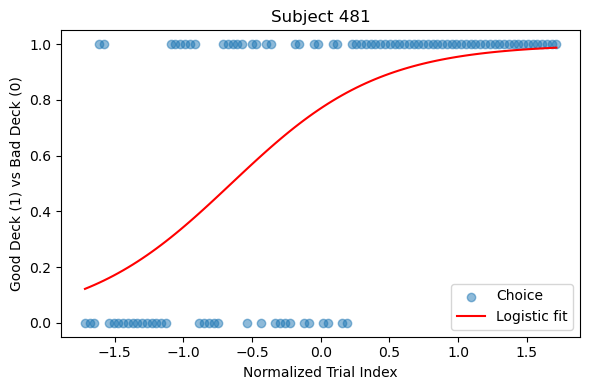

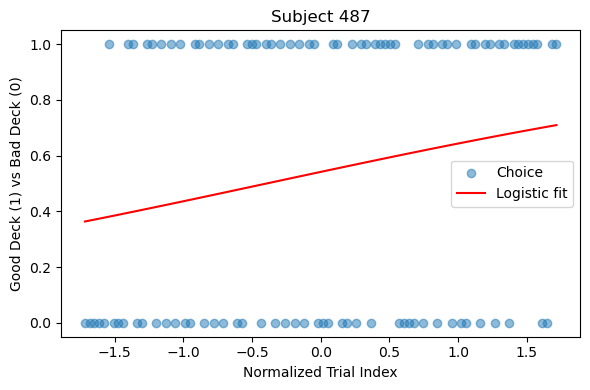

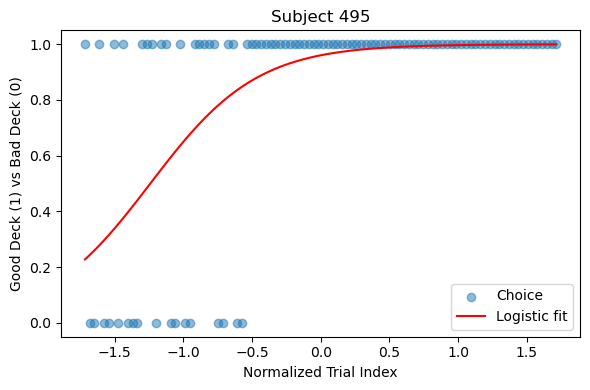

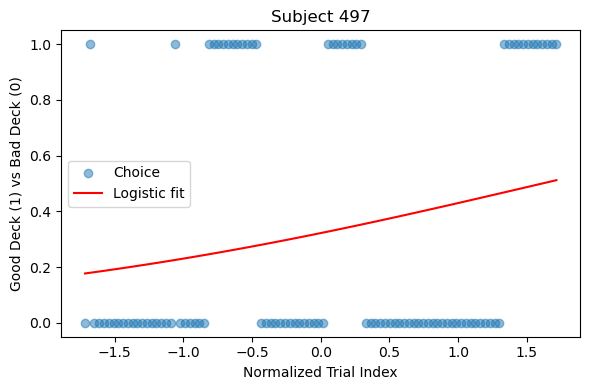

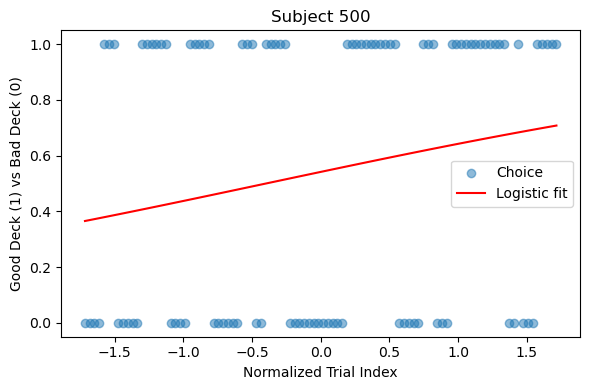

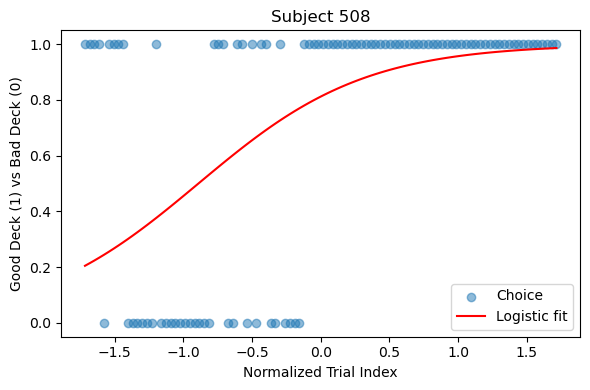

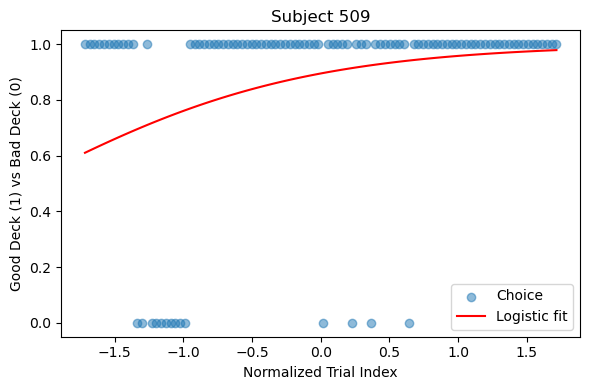

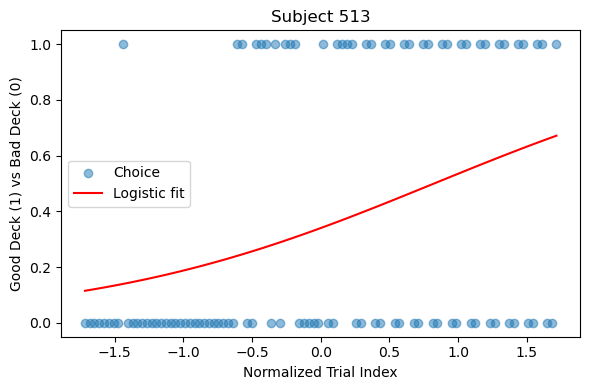

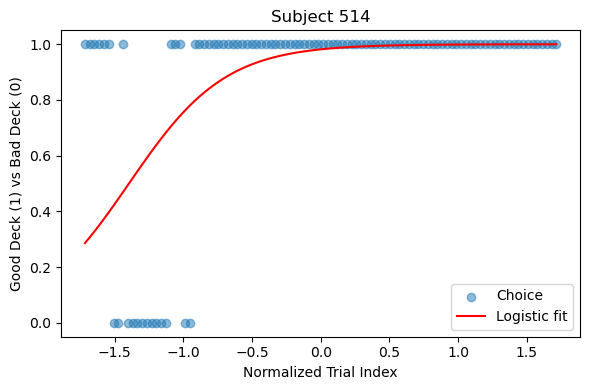

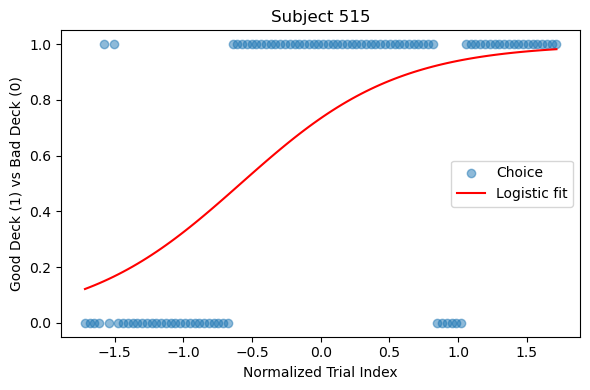

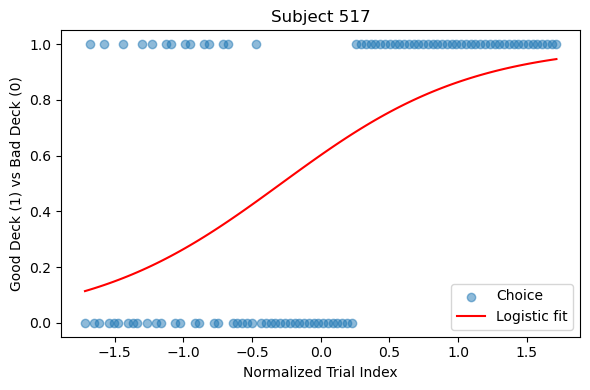

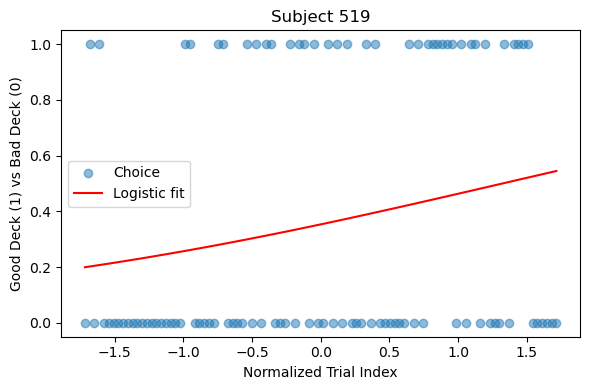

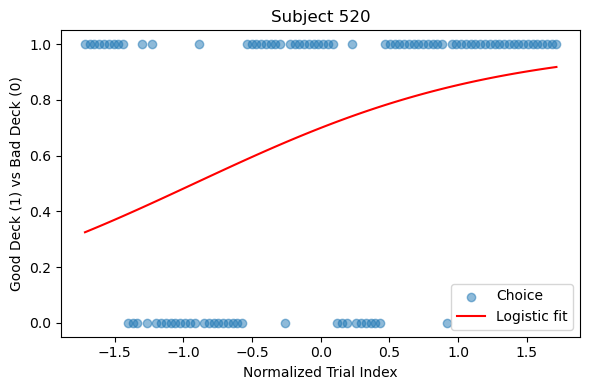

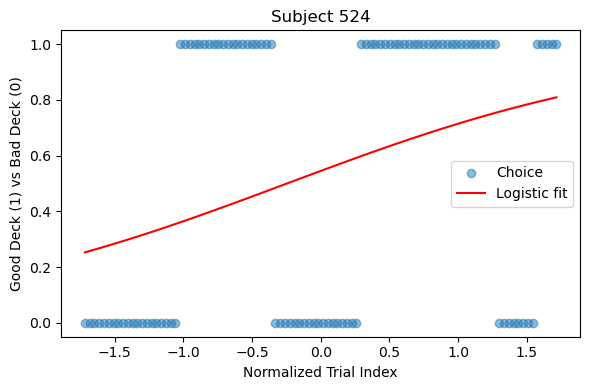

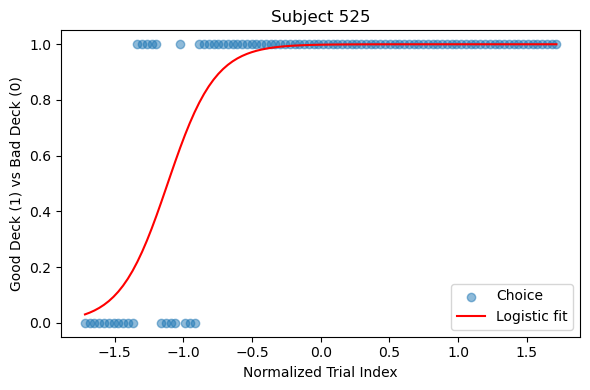

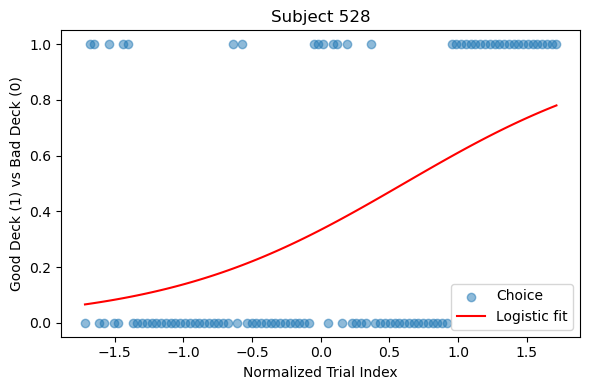

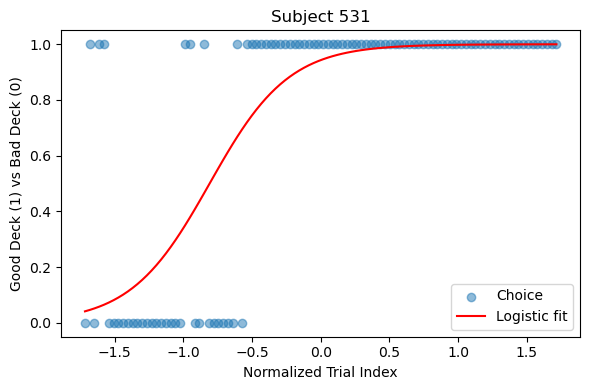

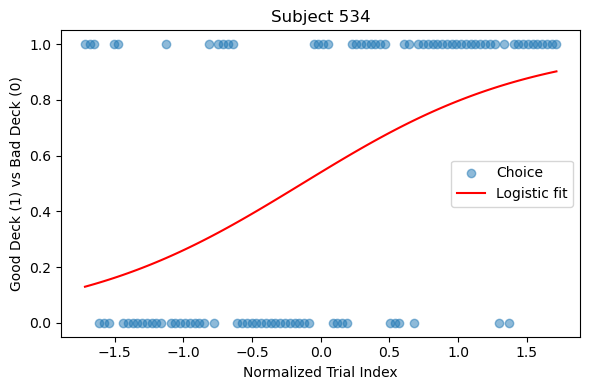

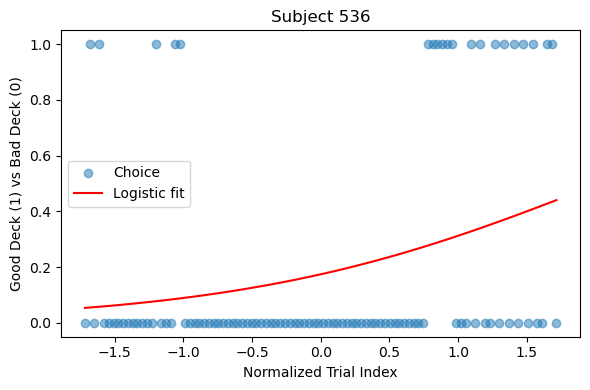

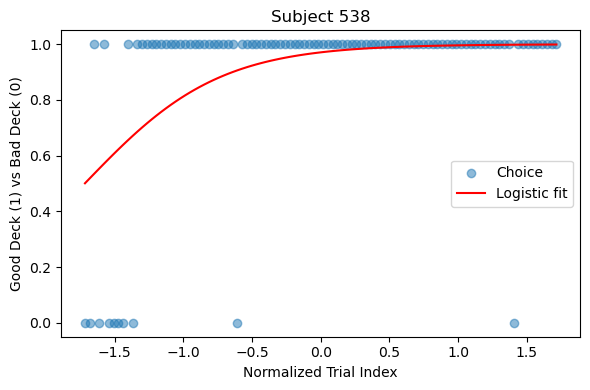

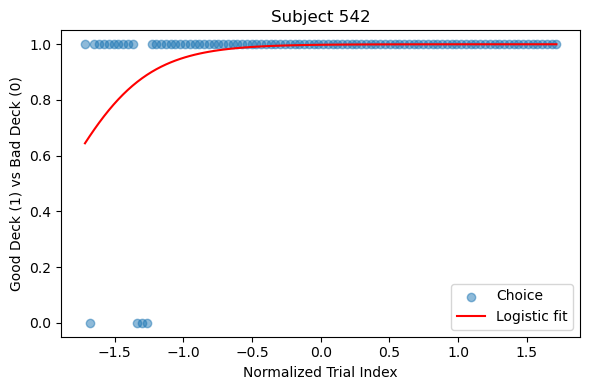

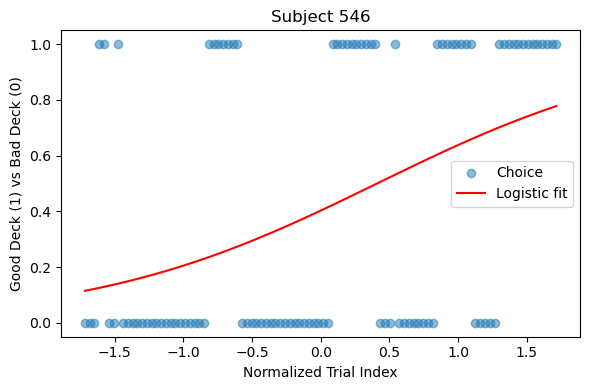

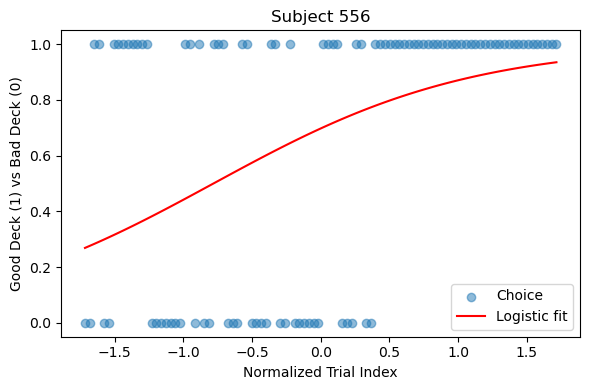

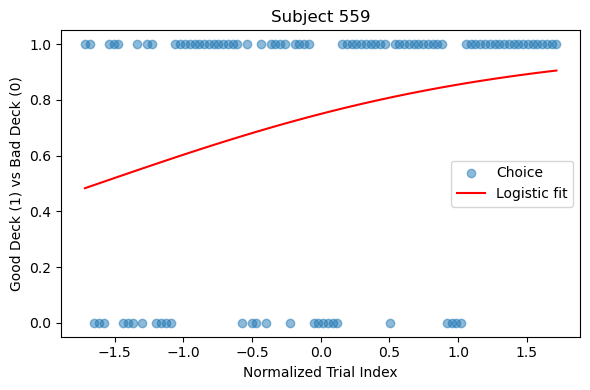

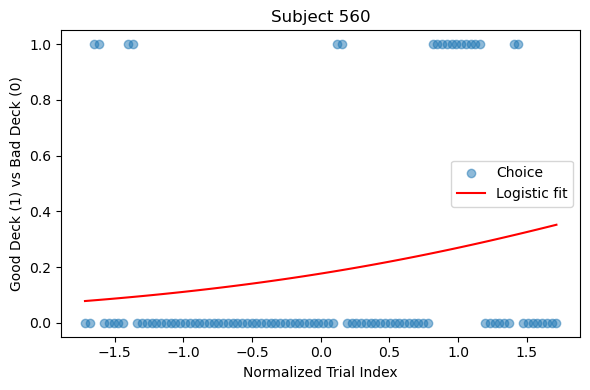

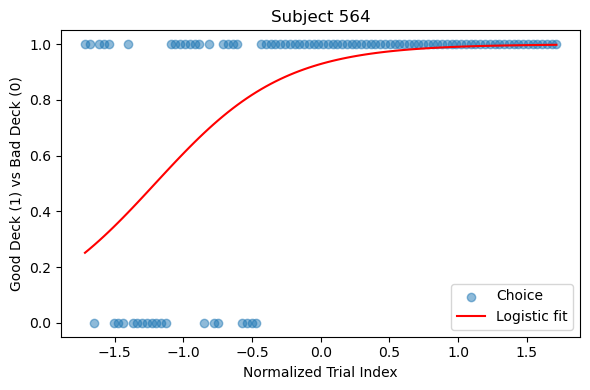

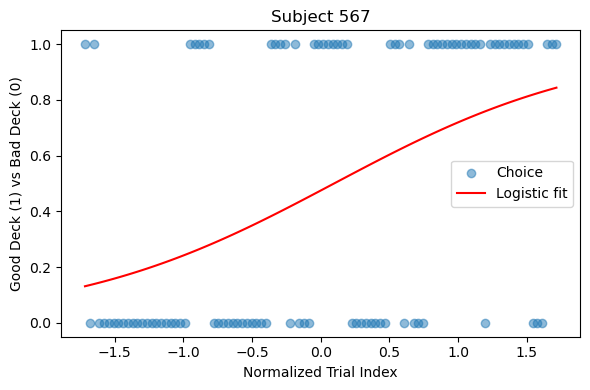

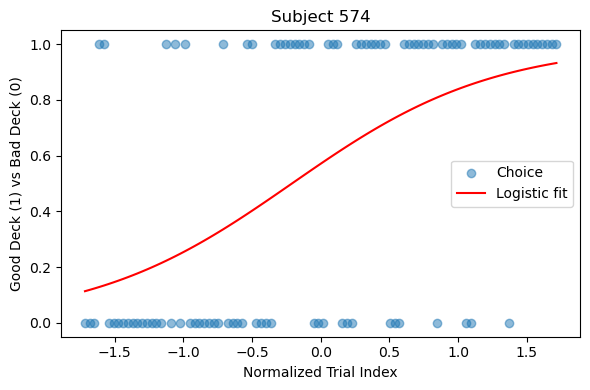

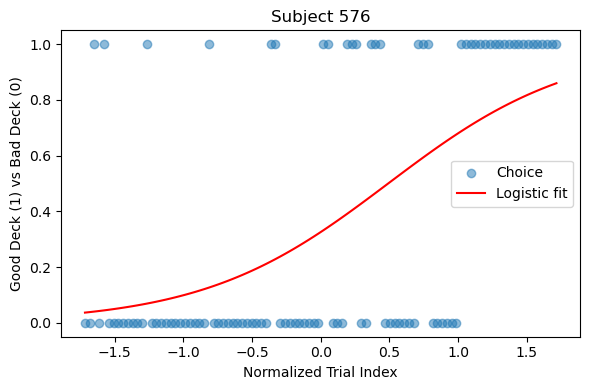

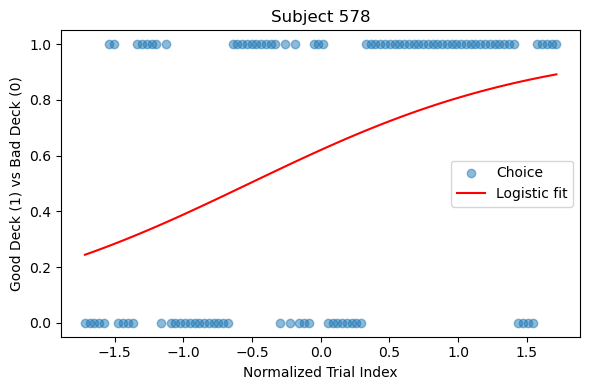

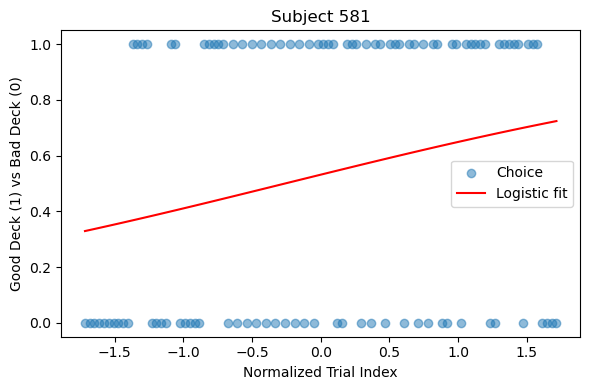

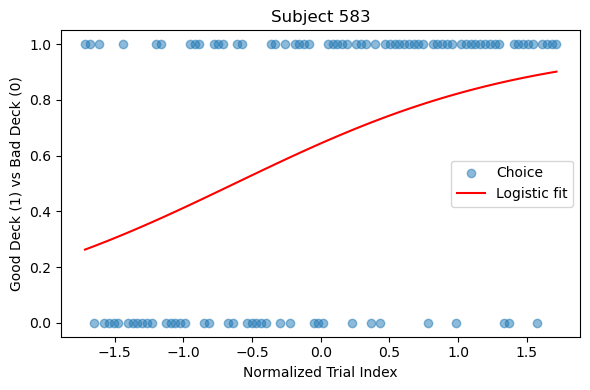

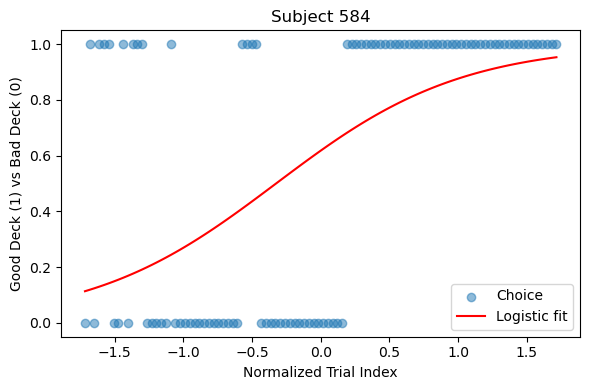

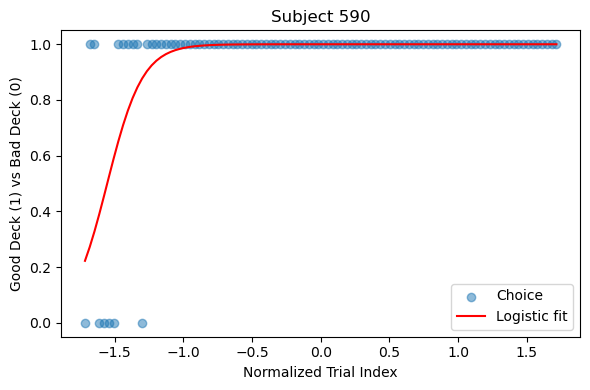

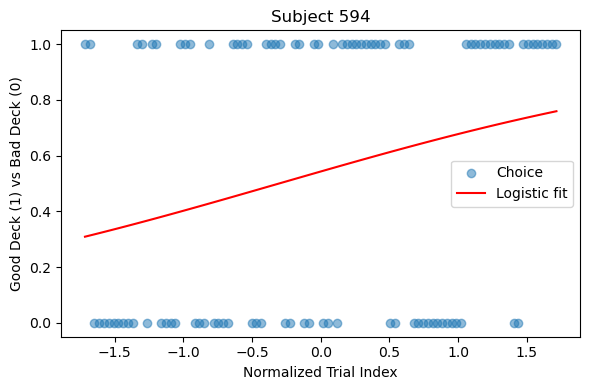

전체 602명 중 학습자 수: 198명


In [13]:
good_decks = {2, 3}
learners = set()

for subj, d in data.items():
    choices = d["choices"]
    y = np.isin(choices, list(good_decks)).astype(int)
    trials = np.arange(len(choices))
    trials_z = (trials - np.mean(trials)) / np.std(trials)
    X = sm.add_constant(trials_z)

    try:
        model = sm.Logit(y, X)
        result = model.fit(disp=False, method='lbfgs', maxiter=200)
        slope = result.params[1]
        pvalue = result.pvalues[1]
        if slope > 0 and pvalue < 0.05:
            learners.add(subj)

            # 시각화
            plt.figure(figsize=(6, 4))
            plt.scatter(trials_z, y, alpha=0.5, label="Choice")

            trial_grid = np.linspace(trials_z.min(), trials_z.max(), 100)
            X_pred = sm.add_constant(trial_grid)
            y_pred = result.predict(X_pred)
            plt.plot(trial_grid, y_pred, color='red', label="Logistic fit")

            plt.title(f"Subject {subj}")
            plt.xlabel("Normalized Trial Index")
            plt.ylabel("Good Deck (1) vs Bad Deck (0)")
            plt.legend()
            plt.tight_layout()
            plt.show()

    except:
        continue

print(f"전체 {len(data)}명 중 학습자 수: {len(learners)}명")